# Signature
----
## Alexandre Dufresne-Nappert
## 20948586
## Oct 08 2025
## https://github.com/MrDNAlex/NE-451-Simulation-Methods/tree/main/Labs/Lab1-Assignment
----

# Generate the Argon FCC Crystal Lattice

In [ ]:
from ase import Atoms
from ase.build import bulk
from ase.io import write

lattice_constant_Ar = 5.26
lattice_constant_Ne = 4.42
lattice_constant_Kr = 5.70

# Example: Create a bulk Argon structure (FCC, lattice a=5.26 Å)
atoms = bulk('Ar', 'fcc', a=lattice_constant_Ar, cubic=True)

# (Optional) Create a 4x4x4 supercell
supercell = atoms.repeat((8, 8, 8))

# Write to a LAMMPS data file
write('Ar.data', supercell, format='lammps-data')

# Example: Create a bulk Neon structure (FCC, lattice a=4.42 Å)
atoms = bulk('Ne', 'fcc', a=lattice_constant_Ne, cubic=True)

# (Optional) Create a 4x4x4 supercell
supercell = atoms.repeat((8, 8, 8))

# Write to a LAMMPS data file
write('Ne.data', supercell, format='lammps-data')

# Example: Create a bulk Krypton structure (FCC, lattice a=5.70 Å)
atoms = bulk('Kr', 'fcc', a=lattice_constant_Kr, cubic=True)

# (Optional) Create a 4x4x4 supercell
supercell = atoms.repeat((8, 8, 8))

# Write to a LAMMPS data file
write('Kr.data', supercell, format='lammps-data')

# Define Simulation Parameters
---

In [24]:
# Define Variables
N = 2048
kb = 1

# Conversions
atmToPascal = 101325
angstrom3Tom3 = 1e-30

# Calculation Variables
simSteps = 1000000
framesPerSave = 100

RDF_Bins = 50

PVNRT_Name_Sim1 = "slurm-528.out"
RDF_Name_Sim1 = "RDF_Sim5.data"


# Read Files
-----

In [25]:
import pandas
import matplotlib.pyplot as plt
import os
import numpy as np

def read_TPVE_File (path : str, equibSteps : int, simSteps : int, saveEveryNFrames: int, include_MSD = False):

    if include_MSD:
        columns = ["Step", "Temp", "Press", "Volume", "TotEng", "MSD", "MSD_Slope"] 
    else:
        columns = ["Step", "Temp", "Press", "Volume", "TotEng"] 

    with open(path, "r") as f:
        totalLineCount = sum(1 for _ in f)

    simLines = simSteps // saveEveryNFrames
    equibLines = equibSteps // saveEveryNFrames

    skipRowsSim = totalLineCount - simLines - 28
    skipRowsEquib = skipRowsSim - equibLines - 34

    df = pandas.read_csv(path, skiprows=skipRowsSim, nrows=simLines + 1 , sep=r"\s+", header=None)
    df_eq = pandas.read_csv(path, skiprows=skipRowsEquib, nrows=equibLines + 1 , sep=r"\s+", header=None)

    df.columns = columns
    df_eq.columns = columns

    return df_eq, df

def read_RDF_File (path : str, n_bins : int):

    columns = [
    "Bin", "r",
    "g_Ar-Ar", "coord_Ar-Ar",
    ]

    with open(path, "r") as f:
        fileSize = len(f.readlines())

    dfs = []

    rdfGroups = (fileSize - 5) // (n_bins + 1)

    for i in range(rdfGroups+1):

        df = pandas.read_csv(path, skiprows=4 + i * (n_bins + 1), nrows = n_bins, sep=r"\s+", header=None)
        df.columns = columns
        dfs.append(df)
    
    return dfs

# Define Plotting Functions
----

In [26]:
def plot_RDF(df: pandas.DataFrame, params: str):

    plt.figure(figsize=(20, 16))

    plt.plot(df["r"], df["g_Ar-Ar"], label="Ar-Ar")

    plt.xlabel("Radius (Å)")
    plt.ylabel("Radial Distribution function - g(r)")
    plt.title(f"The Radial Distribution function of a Argon FCC Crystal Lattice ({params})")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_multi_RDF(dfs: list[pandas.DataFrame], params: str, label : list[str]):

    plt.figure(figsize=(20, 16))

    for i in range(len(dfs)):
        plt.plot(dfs[i]["r"], dfs[i]["g_Ar-Ar"], label=label[i])

    plt.xlabel("Radius (Å)")
    plt.ylabel("Radial Distribution function - g(r)")
    plt.title(f"The Radial Distribution function of a Argon FCC Crystal Lattice ({params})")
    plt.legend()
    plt.grid(True)
    plt.show()

def get_PVNRT (df : pandas.DataFrame):
    steps = df["Step"]
    temp = df["Temp"]
    press = df["Press"]
    volume = df["Volume"]

    term1 = press * volume
    term2 = N * kb * temp

    yVal = term1 - term2

    return steps, yVal

def get_MSD (df : pandas.DataFrame):
    return df["Step"], df["MSD"], df["MSD_Slope"]

def plot_PVRNT(df_eq : pandas.DataFrame, df : pandas.DataFrame, zeroLine : bool = True):
    plt.figure(figsize=(20, 16))
    
    steps_eq, yVal_eq = get_PVNRT(df_eq)
    steps, yVal = get_PVNRT(df)

    plt.plot(steps_eq, yVal_eq, label=f"Argon - Equilibriation")
    plt.plot(steps, yVal, label=f"Argon - Simulation")

    plt.xlabel("Number of Total Steps")
    plt.ylabel("Ideal Gas Law (PV-Nk_BT)")
    plt.title("Plot of the Ideal Gas Law Equation for FCC Argon over the course of a NPT Equilibriation and NVE Simulation")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_multi_MSD(df_eqs : list[pandas.DataFrame], dfs : list[pandas.DataFrame], labels : str):
    plt.figure(figsize=(20, 16))
    
    for i in range(len(df_eqs)):

        steps_eq, msd_eq, msd_slope_eq = get_MSD(df_eqs[i]) 
        steps, msd, msd_slope = get_MSD(dfs[i]) 

        plt.plot(steps_eq, msd_eq, label=f"{labels[i]} - Equilibriation")
        plt.plot(steps, msd, label=f"{labels[i]} - Simulation")

    plt.xlabel("Number of Total Steps")
    plt.ylabel("Mean Square Difference (MSD)")
    plt.title("Plot of the Mean Square Difference for FCC Argon, Neon and Krypton over the course of mutliple NPT Equilibriations and NVE Simulations")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_multi_MSD_Slope(df_eqs : list[pandas.DataFrame], dfs : list[pandas.DataFrame], labels : str):
    plt.figure(figsize=(20, 16))
    
    for i in range(len(df_eqs)):

        steps_eq, msd_eq, msd_slope_eq = get_MSD(df_eqs[i]) 
        steps, msd, msd_slope = get_MSD(dfs[i]) 

        #plt.plot(steps_eq, msd_slope_eq, label=f"{labels[i]} - Equilibriation")
        plt.plot(steps[1:], msd_slope[1:], label=f"{labels[i]} - Simulation")

    plt.xlabel("Number of Total Steps")
    plt.ylabel("Mean Square Difference Slope (MSD)")
    plt.title("Plot of the Mean Square Difference Slope for FCC Argon, Neon and Krypton over the course of mutliple NPT Equilibriations and NVE Simulations")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_multi_PVRNT(df_eqs : list[pandas.DataFrame], dfs : list[pandas.DataFrame], labels : str):
    plt.figure(figsize=(20, 16))
    
    for i in range(len(df_eqs)):
        steps_eq, yVal_eq = get_PVNRT(df_eqs[i])
        steps, yVal = get_PVNRT(dfs[i])

        plt.plot(steps_eq, yVal_eq, label=f"{labels[i]} - Equilibriation")
        plt.plot(steps, yVal, label=f"{labels[i]} - Simulation")

    plt.xlabel("Number of Total Steps")
    plt.ylabel("Ideal Gas Law (PV-Nk_BT)")
    plt.title("Plot of the Ideal Gas Law Equation for FCC Argon over the course of mutliple NPT Equilibriations and NVE Simulations")
    plt.legend()
    plt.grid(True)
    plt.show()

# Read Data Files
-----

In [27]:
# Exercise 1
E1_Sim1_eq,  E1_Sim1= read_TPVE_File("Exercise1&2/slurm-1058.out", 20000, 80000, framesPerSave)

# Exercise 2
# Read the Data from the RDF Files
E2_RDF_eq = read_RDF_File("Exercise1&2/RDF_Pre_Sim1.data", RDF_Bins)
E2_RDF = read_RDF_File("Exercise1&2/RDF_Sim1.data", RDF_Bins)

# Exercise 3
# Read the Data from the SLURM Files
E3_T1_eq,  E3_T1 = read_TPVE_File("Exercise3/slurm-1106.out", 20000, 80000, framesPerSave)
E3_T2_eq,  E3_T2 = read_TPVE_File("Exercise3/slurm-1107.out", 20000, 80000, framesPerSave)
E3_T3_eq,  E3_T3 = read_TPVE_File("Exercise3/slurm-1108.out", 20000, 80000, framesPerSave)
E3_T4_eq,  E3_T4 = read_TPVE_File("Exercise3/slurm-1109.out", 20000, 80000, framesPerSave)

# Read the RDF Data from the RDF Files
E3_T1_RDF_eq = read_RDF_File("Exercise3/RDF_Pre_Sim1.data", RDF_Bins)
E3_T1_RDF = read_RDF_File("Exercise3/RDF_Sim1.data", RDF_Bins)

E3_T2_RDF_eq = read_RDF_File("Exercise3/RDF_Pre_Sim2.data", RDF_Bins)
E3_T2_RDF = read_RDF_File("Exercise3/RDF_Sim2.data", RDF_Bins)

E3_T3_RDF_eq = read_RDF_File("Exercise3/RDF_Pre_Sim3.data", RDF_Bins)
E3_T3_RDF = read_RDF_File("Exercise3/RDF_Sim3.data", RDF_Bins)

E3_T4_RDF_eq = read_RDF_File("Exercise3/RDF_Pre_Sim4.data", RDF_Bins)
E3_T4_RDF = read_RDF_File("Exercise3/RDF_Sim4.data", RDF_Bins)

# Exercise 5
E5_C1_eq,  E5_C1 = read_TPVE_File("Exercise5/slurm-1135.out", 20000, 80000, framesPerSave)
E5_C2_eq,  E5_C2 = read_TPVE_File("Exercise5/slurm-1136.out", 20000, 80000, framesPerSave)
E5_C3_eq,  E5_C3 = read_TPVE_File("Exercise5/slurm-1137.out", 20000, 80000, framesPerSave)
E5_C4_eq,  E5_C4 = read_TPVE_File("Exercise5/slurm-1138.out", 20000, 80000, framesPerSave)

# Read the RDF Data from the RDF Files
E5_C1_RDF_eq = read_RDF_File("Exercise5/RDF_Pre_Sim1.data", RDF_Bins)
E5_C1_RDF = read_RDF_File("Exercise5/RDF_Sim1.data", RDF_Bins)

E5_C2_RDF_eq = read_RDF_File("Exercise5/RDF_Pre_Sim2.data", RDF_Bins)
E5_C2_RDF = read_RDF_File("Exercise5/RDF_Sim2.data", RDF_Bins)

E5_C3_RDF_eq = read_RDF_File("Exercise5/RDF_Pre_Sim3.data", RDF_Bins)
E5_C3_RDF = read_RDF_File("Exercise5/RDF_Sim3.data", RDF_Bins)

E5_C4_RDF_eq = read_RDF_File("Exercise5/RDF_Pre_Sim4.data", RDF_Bins)
E5_C4_RDF = read_RDF_File("Exercise5/RDF_Sim4.data", RDF_Bins)

# Exercise 6
E6_Ar_eq, E6_Ar = read_TPVE_File("Exercise6/slurm-1195.out", 20000, 80000, framesPerSave, True)

E6_Ar_eq, E6_Ar = read_TPVE_File("Exercise6/slurm-1261.out", 20000, 80000, framesPerSave, True)
E6_Ne_eq, E6_Ne = read_TPVE_File("Exercise6/slurm-1262.out", 20000, 80000, framesPerSave, True)
E6_Kr_eq, E6_Kr = read_TPVE_File("Exercise6/slurm-1263.out", 20000, 80000, framesPerSave, True)

# Exercise 1 : Plot the PV - Nk_BT Graph
----
## Instructions
----
1. Run the provided LAMMPS script. 
2. Extract pressure P, volume V, number of atoms N, Boltzmann constant kB, and temperature T. 
3. Calculate PV −NkBT at each timestep and plot.

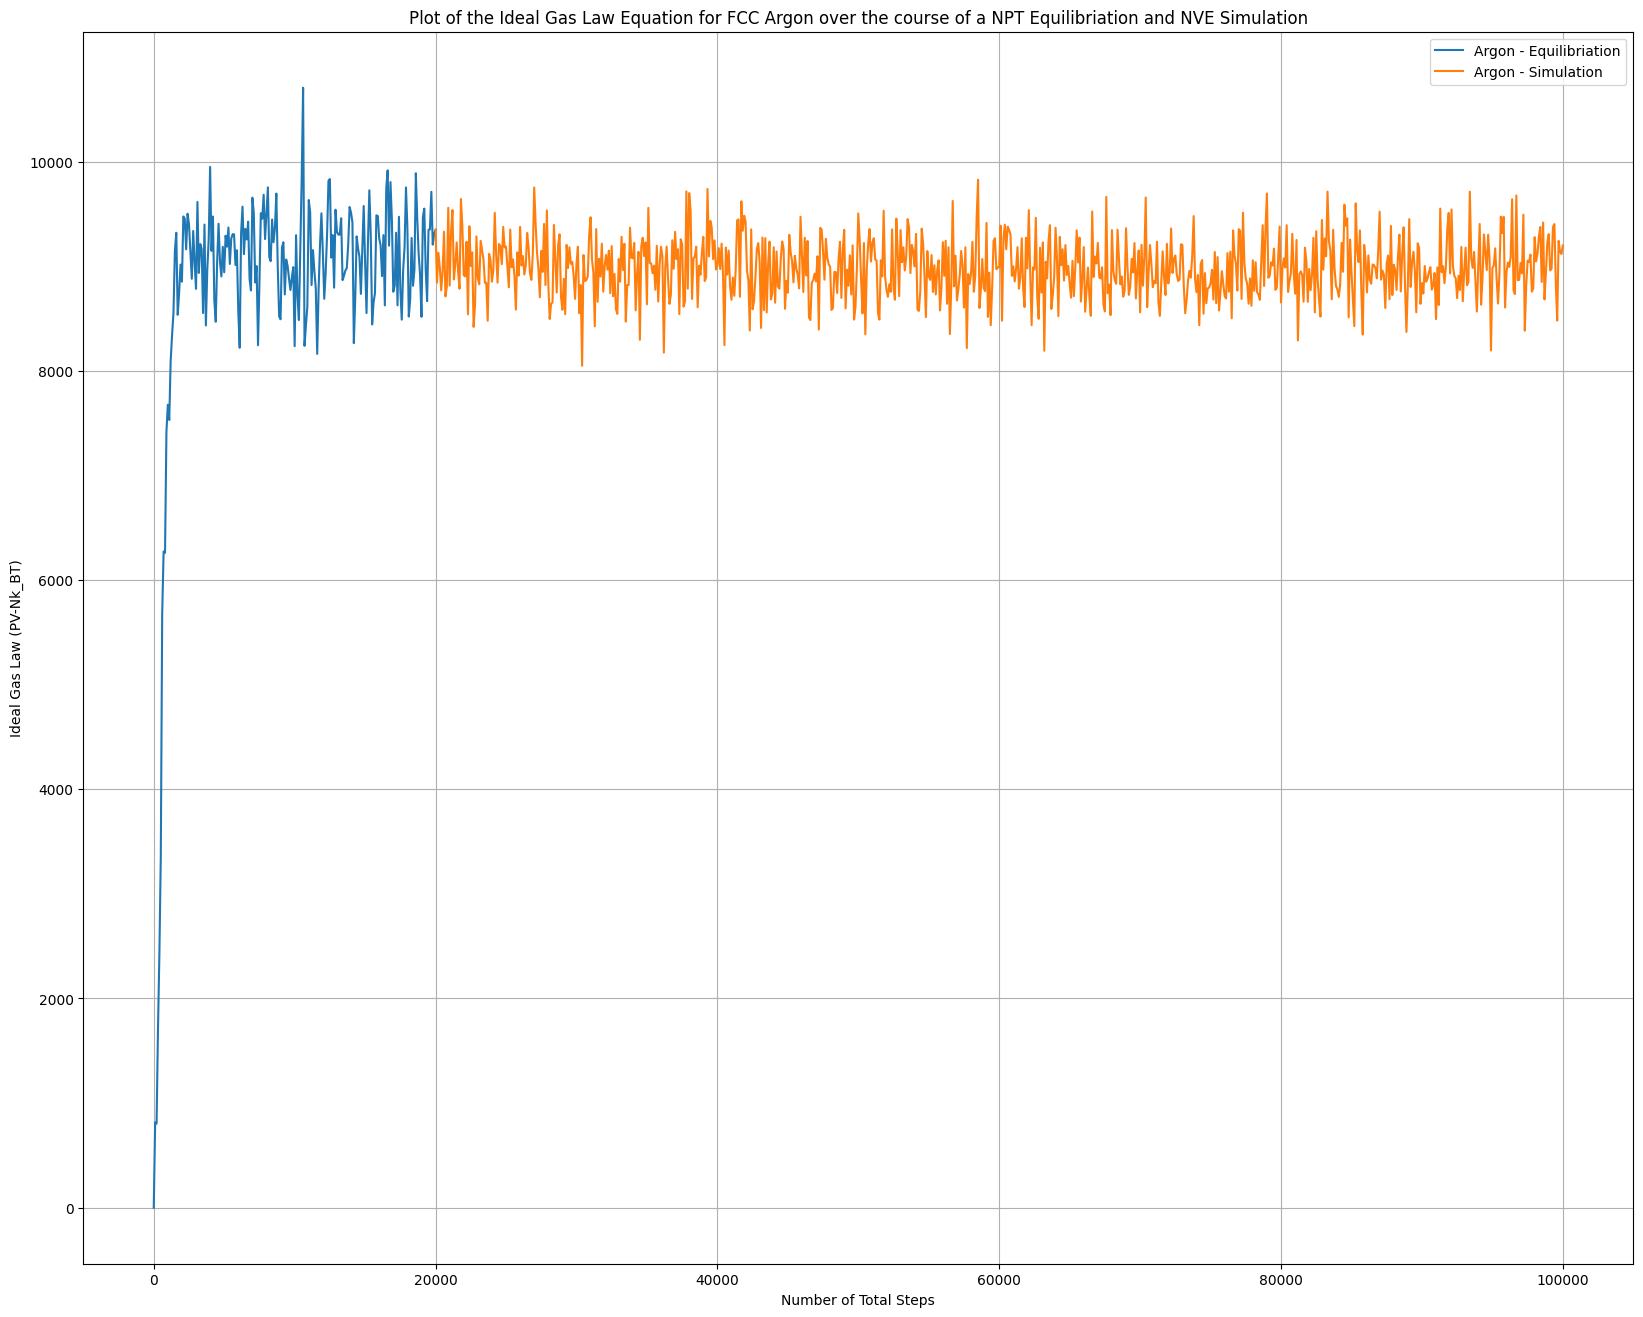

In [28]:
# Plot the Ideal Gas Law over the entire simulation
plot_PVRNT(E1_Sim1_eq, E1_Sim1)

## Questions
----
### Does PV-N$k_B$T fluctuate? Why?
-----
The PV-N$k_B$T equation fluctuates in the simulation because we do not lock the variables T (Temperature) and P (Pressure), this means that within the simulation, the variables can fluctuate which makes it so that the entire function will fluctuate around the average. While the function fluctuates over a short period of time, the average of the function would properly follow the Ideal Gas Law Equation. Some fluctuations may also be coming from the Velocity Verlet algorithm being used for the NVE Simulation (https://docs.lammps.org/fix_nve.html). Small errors may occur during the integration which translates to the atoms speeds and finally the directly affects the temperature and pressure of the system.

### How does it compare to the Ideal Gas Law
----
Normally in Molecular Dynamics Simulations we will calculate the Temperature using :
$$T = \frac{\langle v_a^2 \rangle m}{k_B}$$

This means the temperature is dependent on the Kinetic Energy or velocity of the Molecules. For the Ideal gas we are dependent on the Temperature, Pressure, Number of Atoms and Volume, where the Temperature and Pressure end up fluctuating. The Ideal Gas explanation will experience some fluctuations in short time frames aswell, but overall we are concerned with large time scales or averages, so over the course of the simulation the average should yield the same result as the Ideal Gas Equation.

# Exercise 2 : Plot the Radial Function
----
## Instructions
---
1. Compute RDF in LAMMPS or post-processing tools (Ovito/VMD). 
2. Plot g(r) vs distance r.

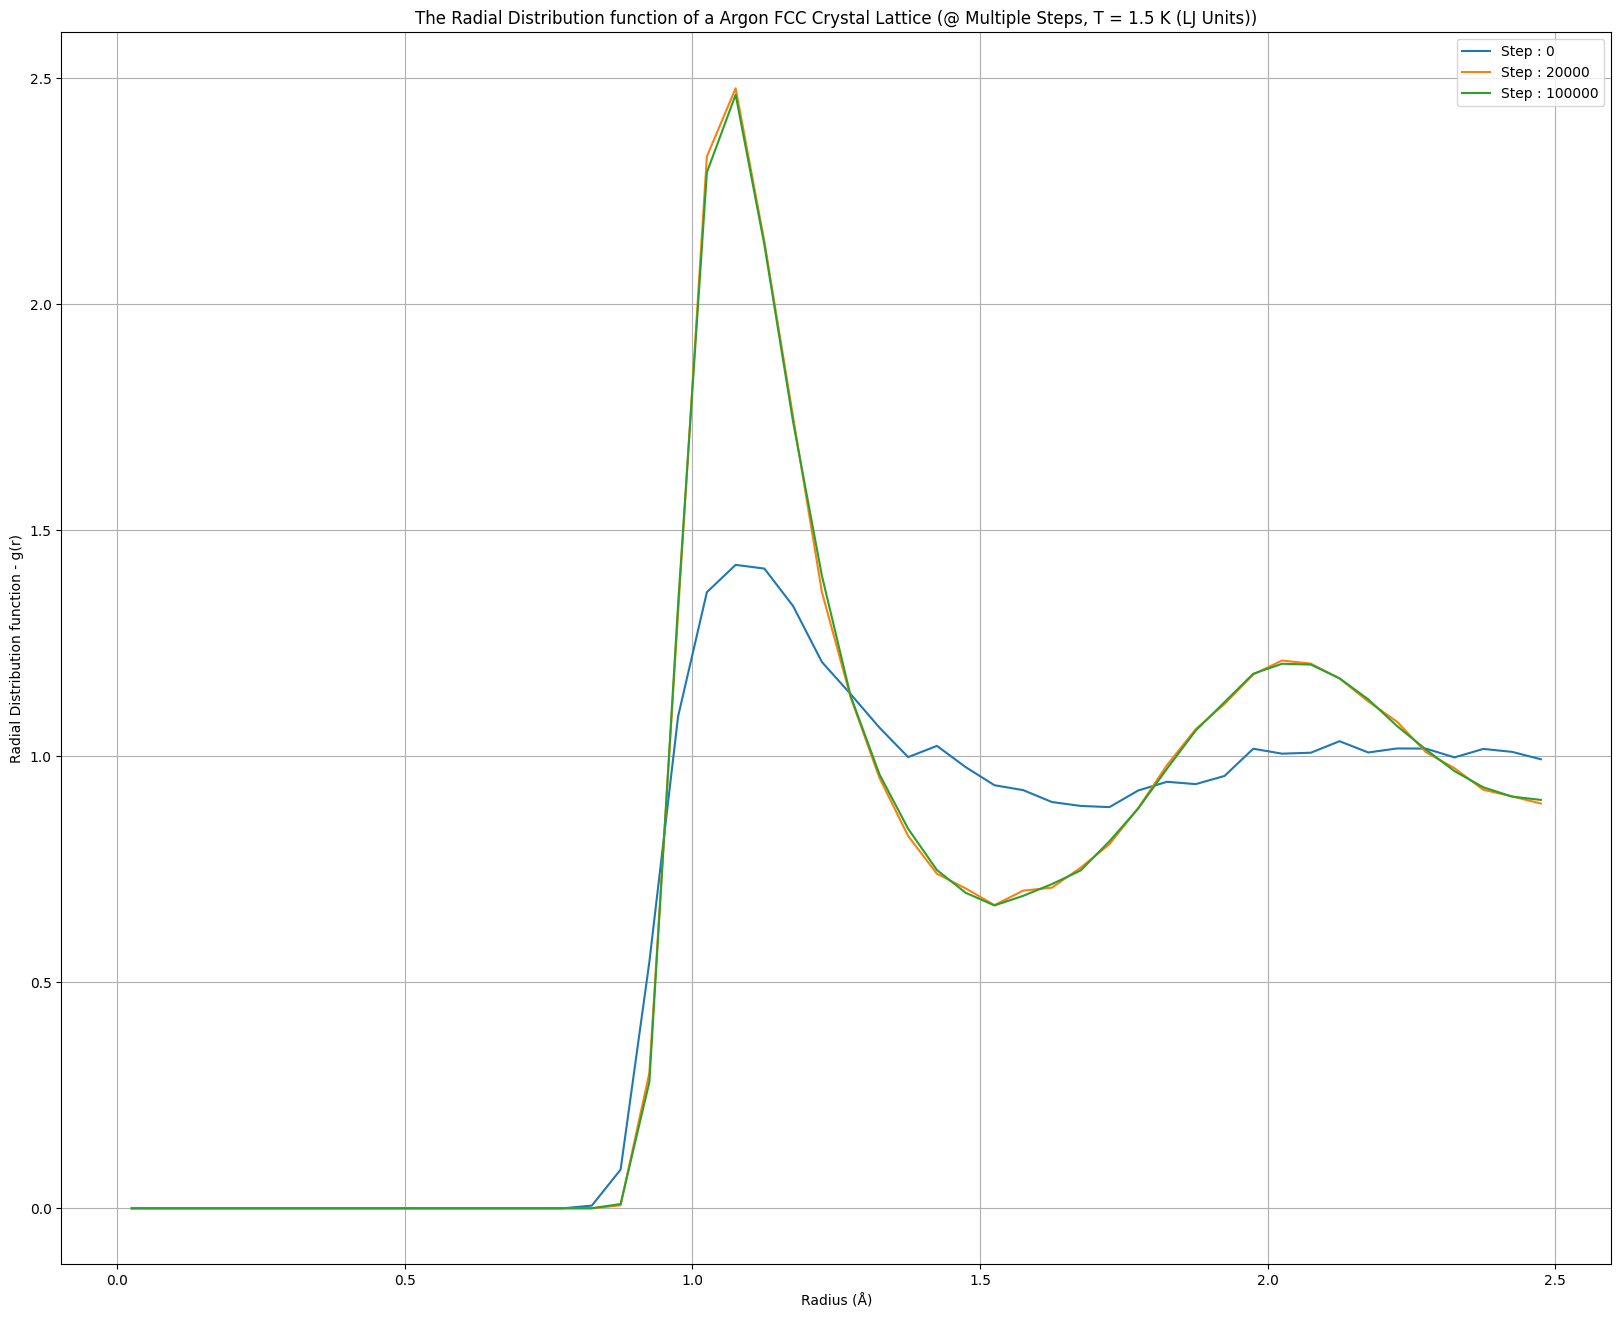

In [29]:
# Create an array of Dataframes and define their labels
dfs = [ E2_RDF_eq[0], E2_RDF_eq[-1], E2_RDF[-1]]
labels = [ "Step : 0", "Step : 20000", "Step : 100000"]

# Plot the RDF Function
plot_multi_RDF(dfs, "@ Multiple Steps, T = 1.5 K (LJ Units)", labels)


## Questions
----
### Whatdoes the shape of g(r) indicate about local structure?
----
The `g(r)` functions shape describes the local density of neighboring atoms within the volume. Meaning that from any random atom within the volume, we can expect to find Y atoms from distance X away from the atom. If we were to integrate the g(r) function up to a peak, you can calculate the total number of neighboring atoms within that distance.

### Identify peaks and their physical meaning.
----
The peaks are located at 1.05 and 2.05 angstroms, the peak at 1.05 Ansgtroms indicate the first few closest neighbours to the argon atom, if we were to integrate the area under the curve we could calculate the total number of neighbours to the Argon Atom. The second peak at 2.05 Angstroms shows the Argons second coordination shell, these show the second "layer" of closest neighbouring atoms


# Exercise 3 : Temperature Effects on PV-Nk_BT and RDF
----
## Instructions
----
1. Modify initial temperature in the LAMMPS script via 'velocity all create'
2. Re-run simulations at different temperatures.
3. Calculate PV −NkBT and RDF for each temperature.
4. Plot results.

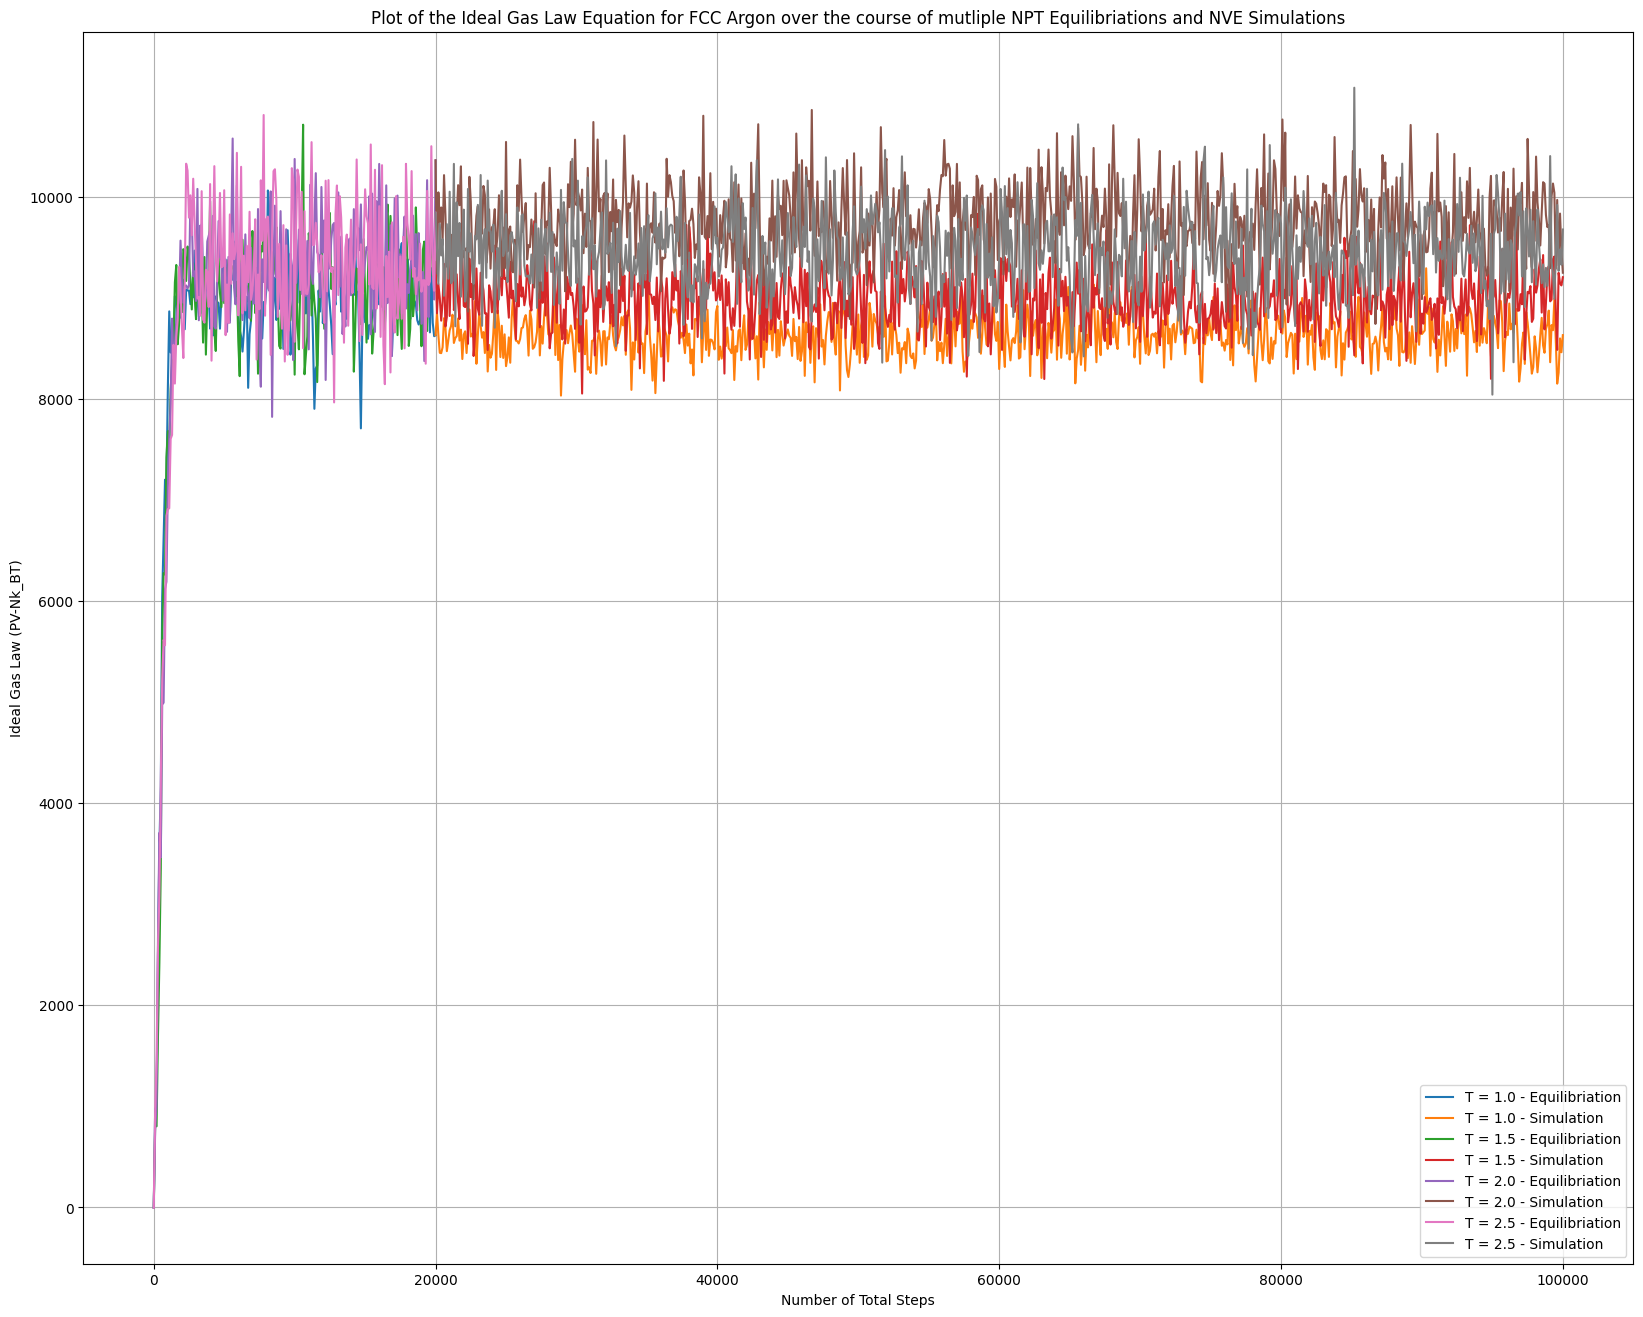

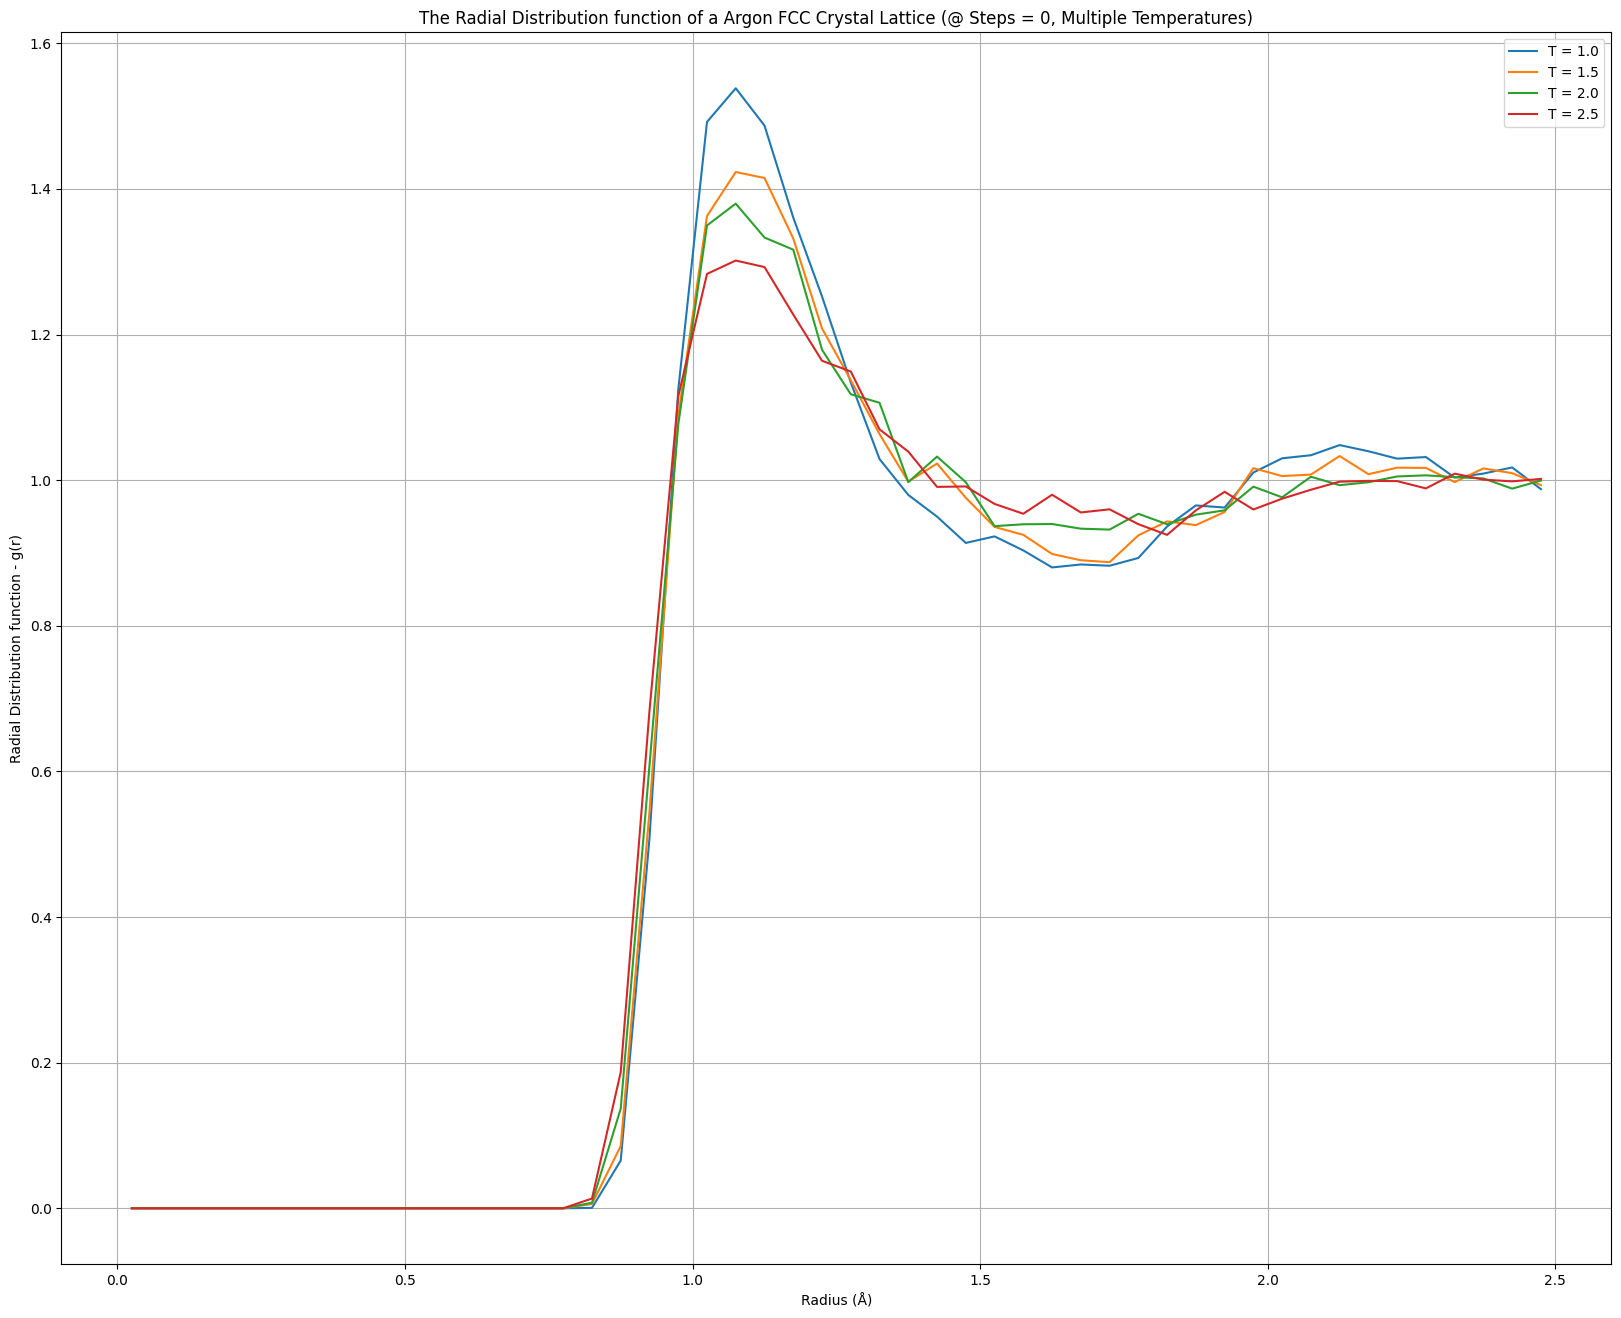

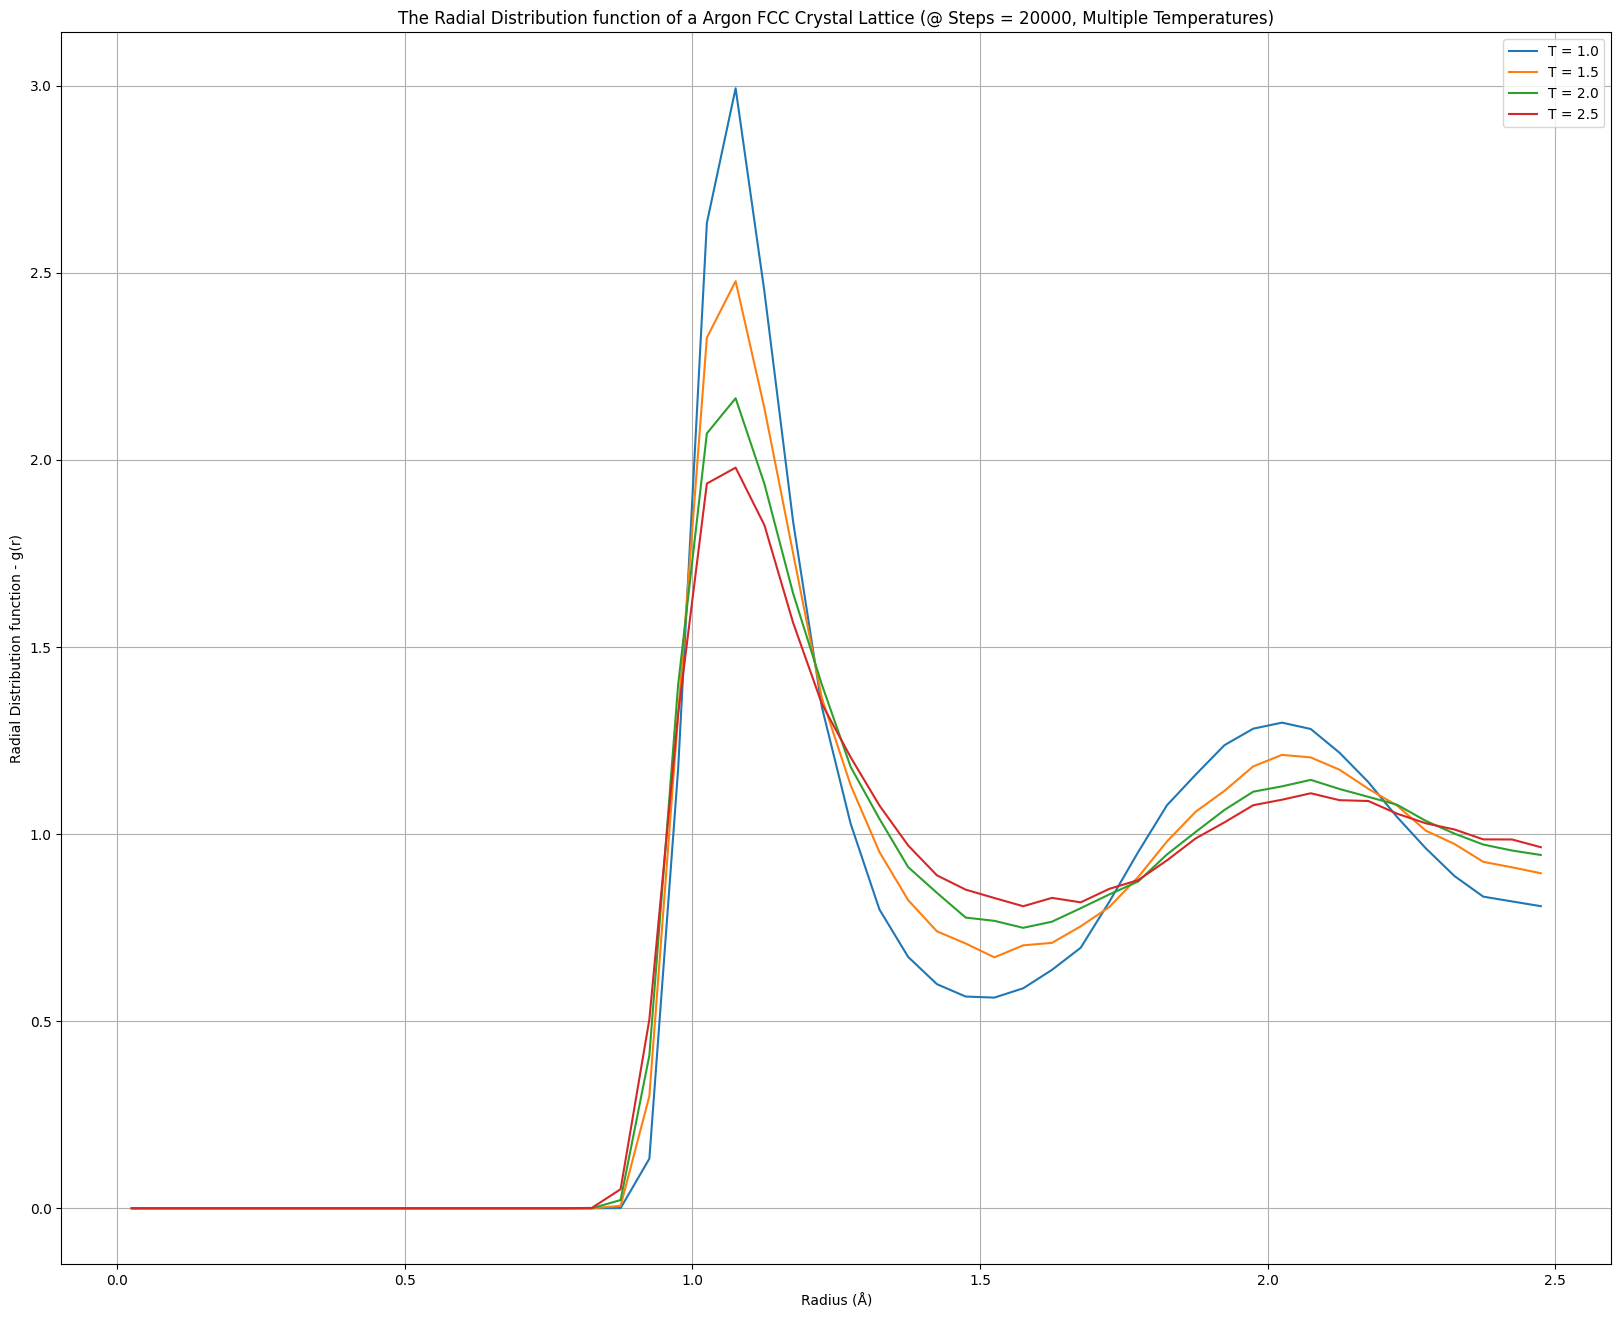

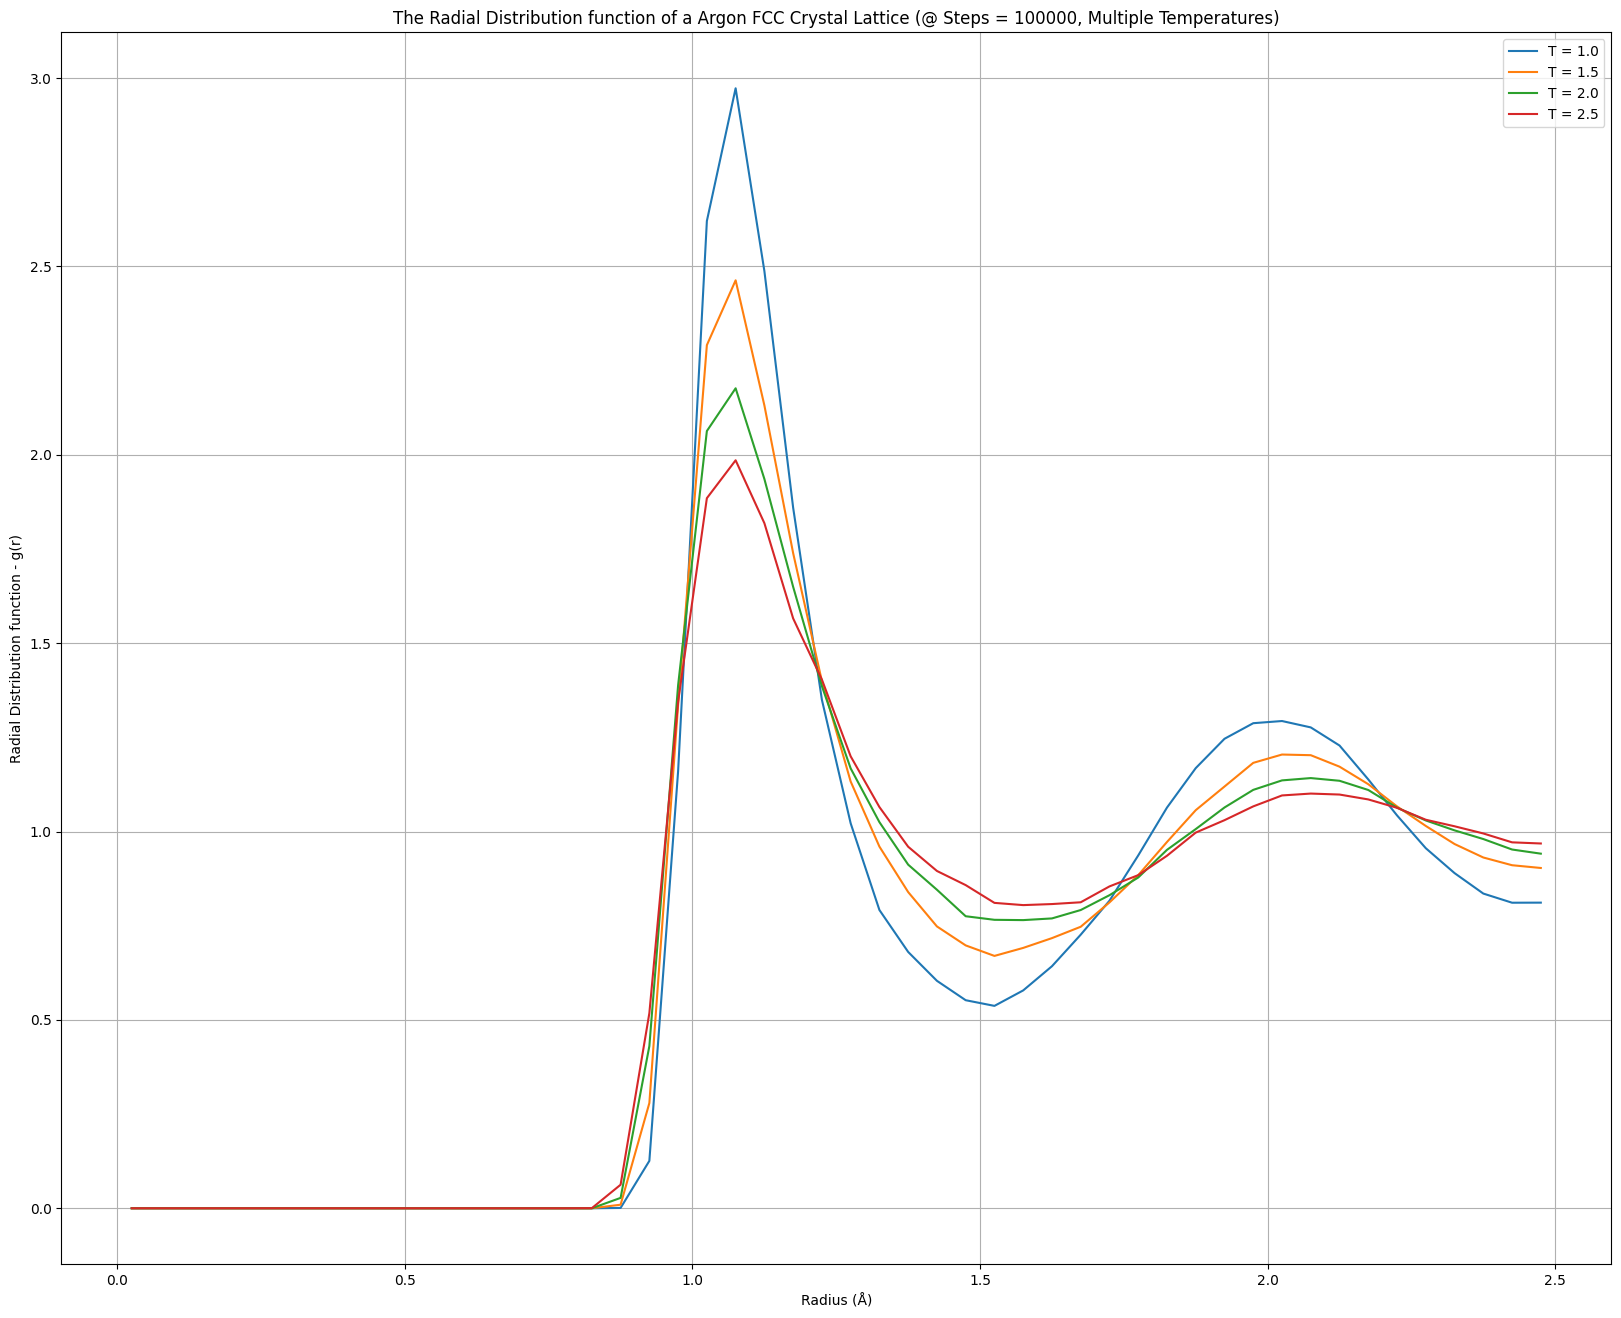

In [30]:
# Create the Labels
labels = ["T = 1.0", "T = 1.5", "T = 2.0", "T = 2.5"]

# Arrange the PVNRT Dataframes into arrays for multi plotting
df_eq = [E3_T1_eq, E3_T2_eq, E3_T3_eq, E3_T4_eq]
df = [E3_T1, E3_T2, E3_T3, E3_T4]

# PLot the PVNRT Comaparisons
plot_multi_PVRNT(df_eq, df, labels)

# Arrange the RDf Dataframes into arraus for multi plotting
dfs1 = [E3_T1_RDF_eq[0], E3_T2_RDF_eq[0], E3_T3_RDF_eq[0], E3_T4_RDF_eq[0]]
dfs2 = [E3_T1_RDF_eq[-1], E3_T2_RDF_eq[-1], E3_T3_RDF_eq[-1], E3_T4_RDF_eq[-1]]
dfs3 = [E3_T1_RDF[-1], E3_T2_RDF[-1], E3_T3_RDF[-1], E3_T4_RDF[-1]]

# Plot the RDF Comparisons
plot_multi_RDF(dfs1, "@ Steps = 0, Multiple Temperatures", labels)
plot_multi_RDF(dfs2, "@ Steps = 20000, Multiple Temperatures", labels)
plot_multi_RDF(dfs3, "@ Steps = 100000, Multiple Temperatures", labels)


## Questions
----
### 1. How does PV − NkBT change with temperature?
----
No major effects occur to the PV - NkBT plot as we change the temperature, using increments of 0.5 LJ Temperature units we can observe that the simulation will equilibriate / average at a slightly higher point with a higher temperature as a general trend, but the T = 2.0 being a slight exception. While at first glance this may not seem intuitive since based off the equation we would expect the average to go down, but this indicates that the Volume settled in Equilibriation and Pressure during the simulation are larger than than the increase in temperature of the system.

### 2. How does the RDF Change? Why?
----
Using increments of 0.5 LJ Temperature units, we can observe from the RDF plot that as the temperature goes higher, the g(r) distributions peaks become smaller, while the troughs become smaller. This makes intuitive sense because at higher temperatures the system is more capable of diffusing and averaging the atoms out over the space instead of keeping a "neat" structure. Since the temperatures are higher, with higher velocities the atoms will have more space between them and will be spread out more evenly in a system behaving closer to an ideal gas

# Exercise 4 : Average Pressure and Volume
----
## Instructions
---
1. Compute average P and V from thermodynamic output.
2. Use these values in PV − NkBT.

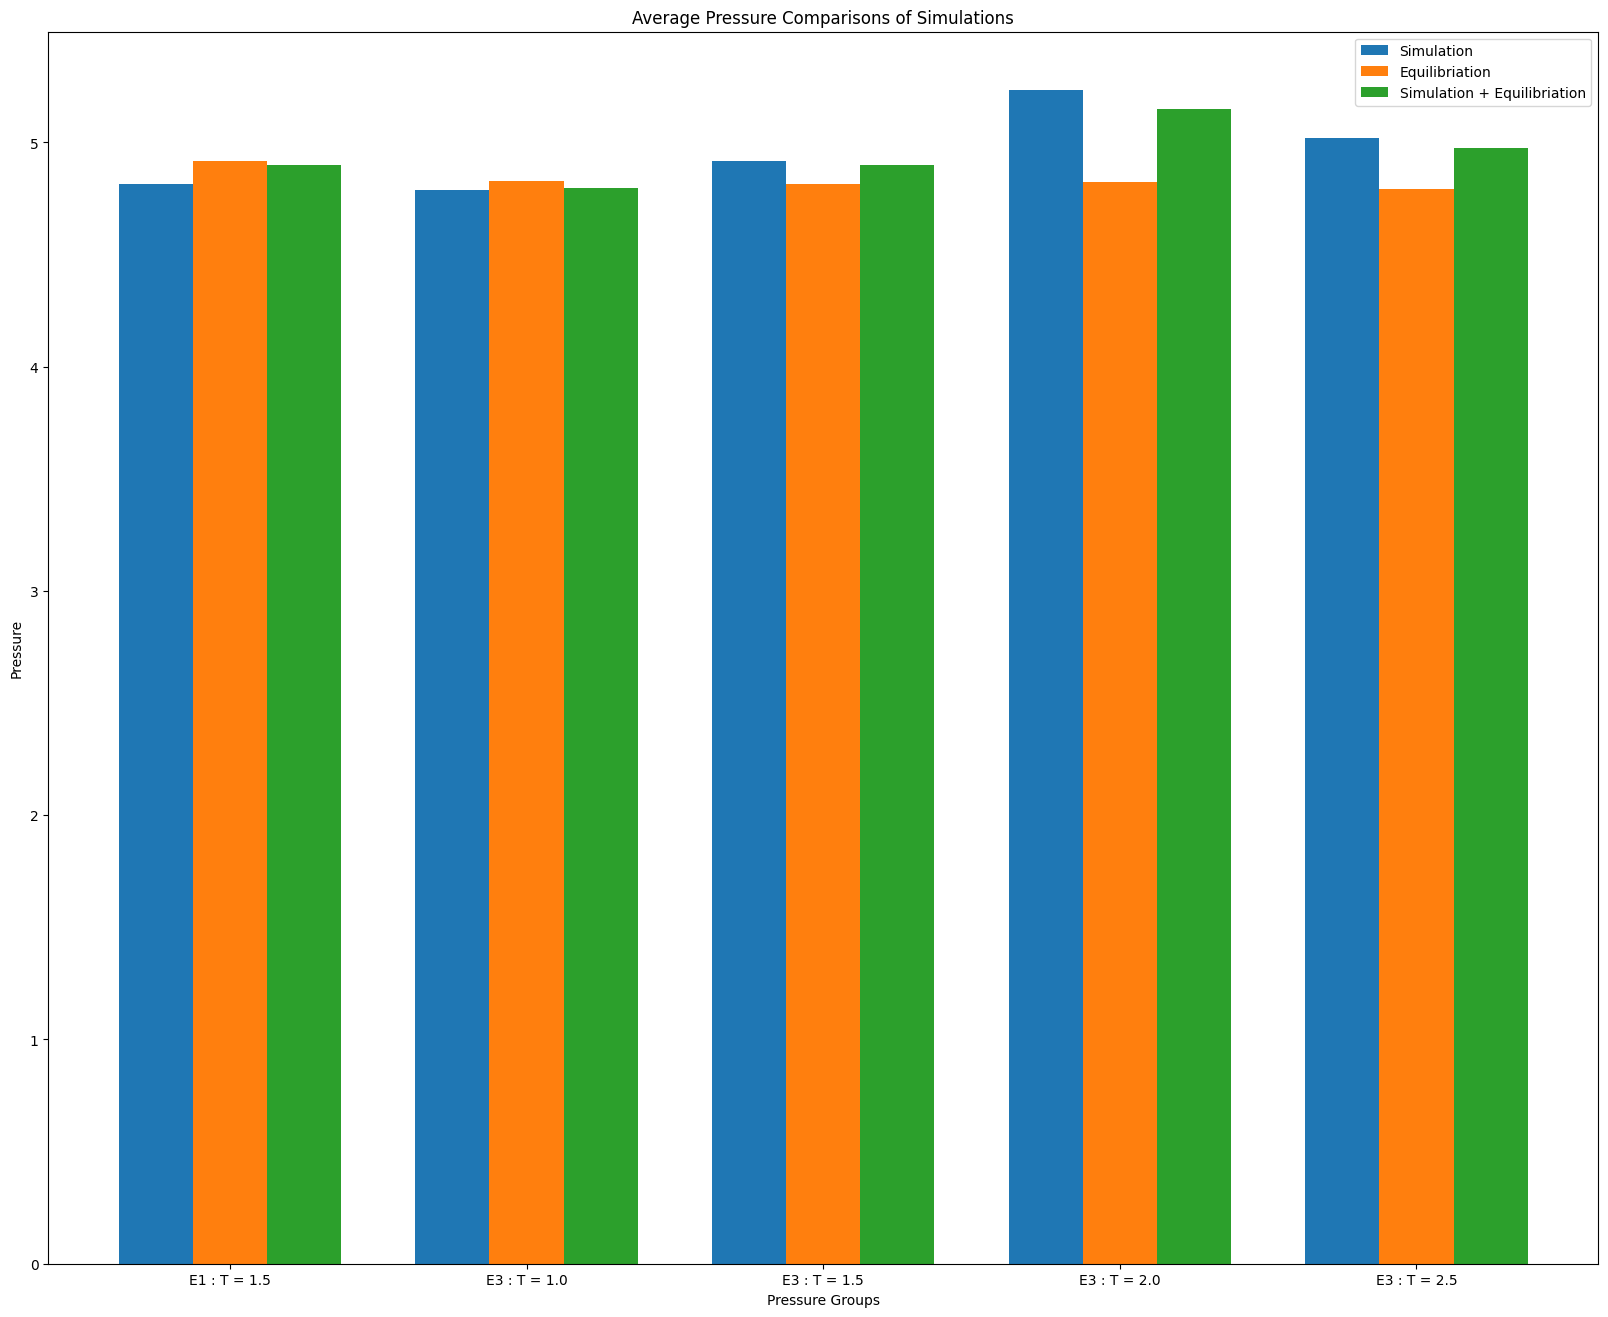

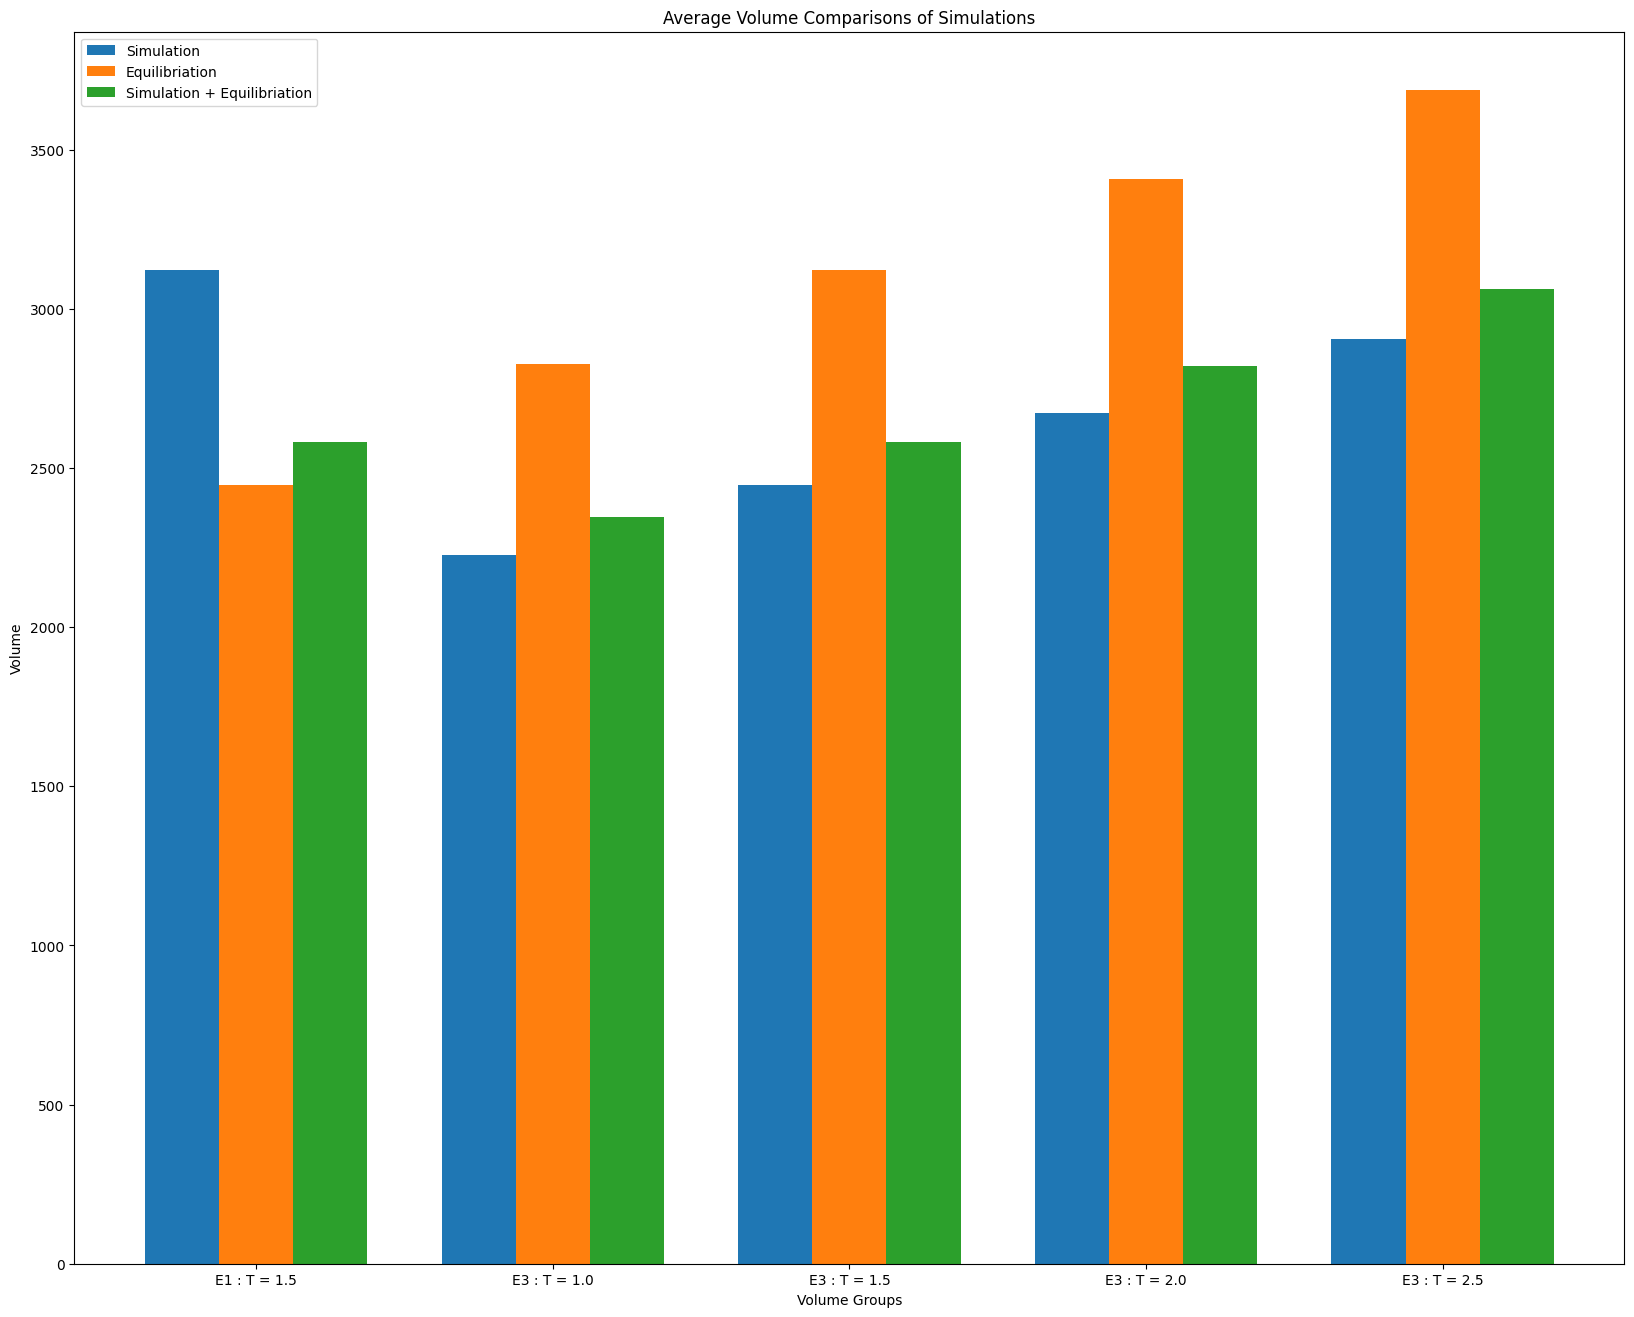

In [31]:
def get_averages(df_eq, df):

    Pressure_Avg = np.average(df["Press"])
    Volume_Avg = np.average(df["Volume"])

    Pressure_Avg_Eq = np.average(df_eq["Press"])
    Volume_Avg_Eq = np.average(df_eq["Volume"])

    Pressure_Avg_Full = np.average(pandas.concat([df_eq["Press"], df["Press"]]))
    Volume_Avg_Full  = np.average(pandas.concat([df_eq["Volume"], df["Volume"]]))

    return Pressure_Avg, Volume_Avg, Pressure_Avg_Eq, Volume_Avg_Eq, Pressure_Avg_Full, Volume_Avg_Full

group_names = ["E1 : T = 1.5", "E3 : T = 1.0", "E3 : T = 1.5", "E3 : T = 2.0", "E3 : T = 2.5"]
# X locations for groups
x = np.arange(len(group_names))
width = 0.25  # width of each bar


averages = np.zeros((5, 6))
averages[0] = get_averages(E1_Sim1, E1_Sim1_eq)
averages[1] = get_averages(E3_T1_eq, E3_T1)
averages[2] = get_averages(E3_T2_eq, E3_T2)
averages[3] = get_averages(E3_T3_eq, E3_T3)
averages[4] = get_averages(E3_T4_eq, E3_T4)

# Plot the Avergae Pressures
# Create the grouped bars
fig, ax = plt.subplots(figsize=(20, 16))
bar1 = ax.bar(x - width, averages[:, 0], width, label="Simulation")
bar2 = ax.bar(x, averages[:, 2], width, label="Equilibriation")
bar2 = ax.bar(x + width, averages[:, 4], width, label="Simulation + Equilibriation")

# Labeling
ax.set_xlabel("Pressure Groups")
ax.set_ylabel("Pressure")
ax.set_title("Average Pressure Comparisons of Simulations")
ax.set_xticks(x)
ax.set_xticklabels(group_names)
ax.legend()

plt.show()

# Plot Average Volumes
# Create the grouped bars
fig, ax = plt.subplots(figsize=(20, 16))
bar1 = ax.bar(x - width, averages[:, 1], width, label="Simulation")
bar2 = ax.bar(x, averages[:, 3], width, label="Equilibriation")
bar2 = ax.bar(x + width, averages[:, 5], width, label="Simulation + Equilibriation")

# Labeling
ax.set_xlabel("Volume Groups")
ax.set_ylabel("Volume")
ax.set_title("Average Volume Comparisons of Simulations")
ax.set_xticks(x)
ax.set_xticklabels(group_names)
ax.legend()

plt.show()

## Questions
-----
### Compare with timestep-by-timestep calculation.
----
In the case of average pressure, there isn't a major difference betweend each simualtions average. There is a slight increase as the temperature increases, but overall they all hover around 5 which is set for the NPT Equilibrium phase, just like in exercise 3, the T = 2.0 poses as a slight anomoly but it does follow the overall trend. The Volume on the other hand has larger 

### Explain differences between instantaneous and averaged values
-----
The instantaneous values of the pressure and volume end up showing their values at each step (or 100 steps in our case) of the simulation, this can show fluctuations that occur over the course of the simualtion. The average over a long enough time is meant to represent their values in a steady-state case.


# Exercise 5 : Effect of Interaction Potential
-----
## Instructions
-----
1. Change Lennard-Jones cutoff in LAMMPS script.
2. Re-run simulation and recompute PV −NkBT and RDF.

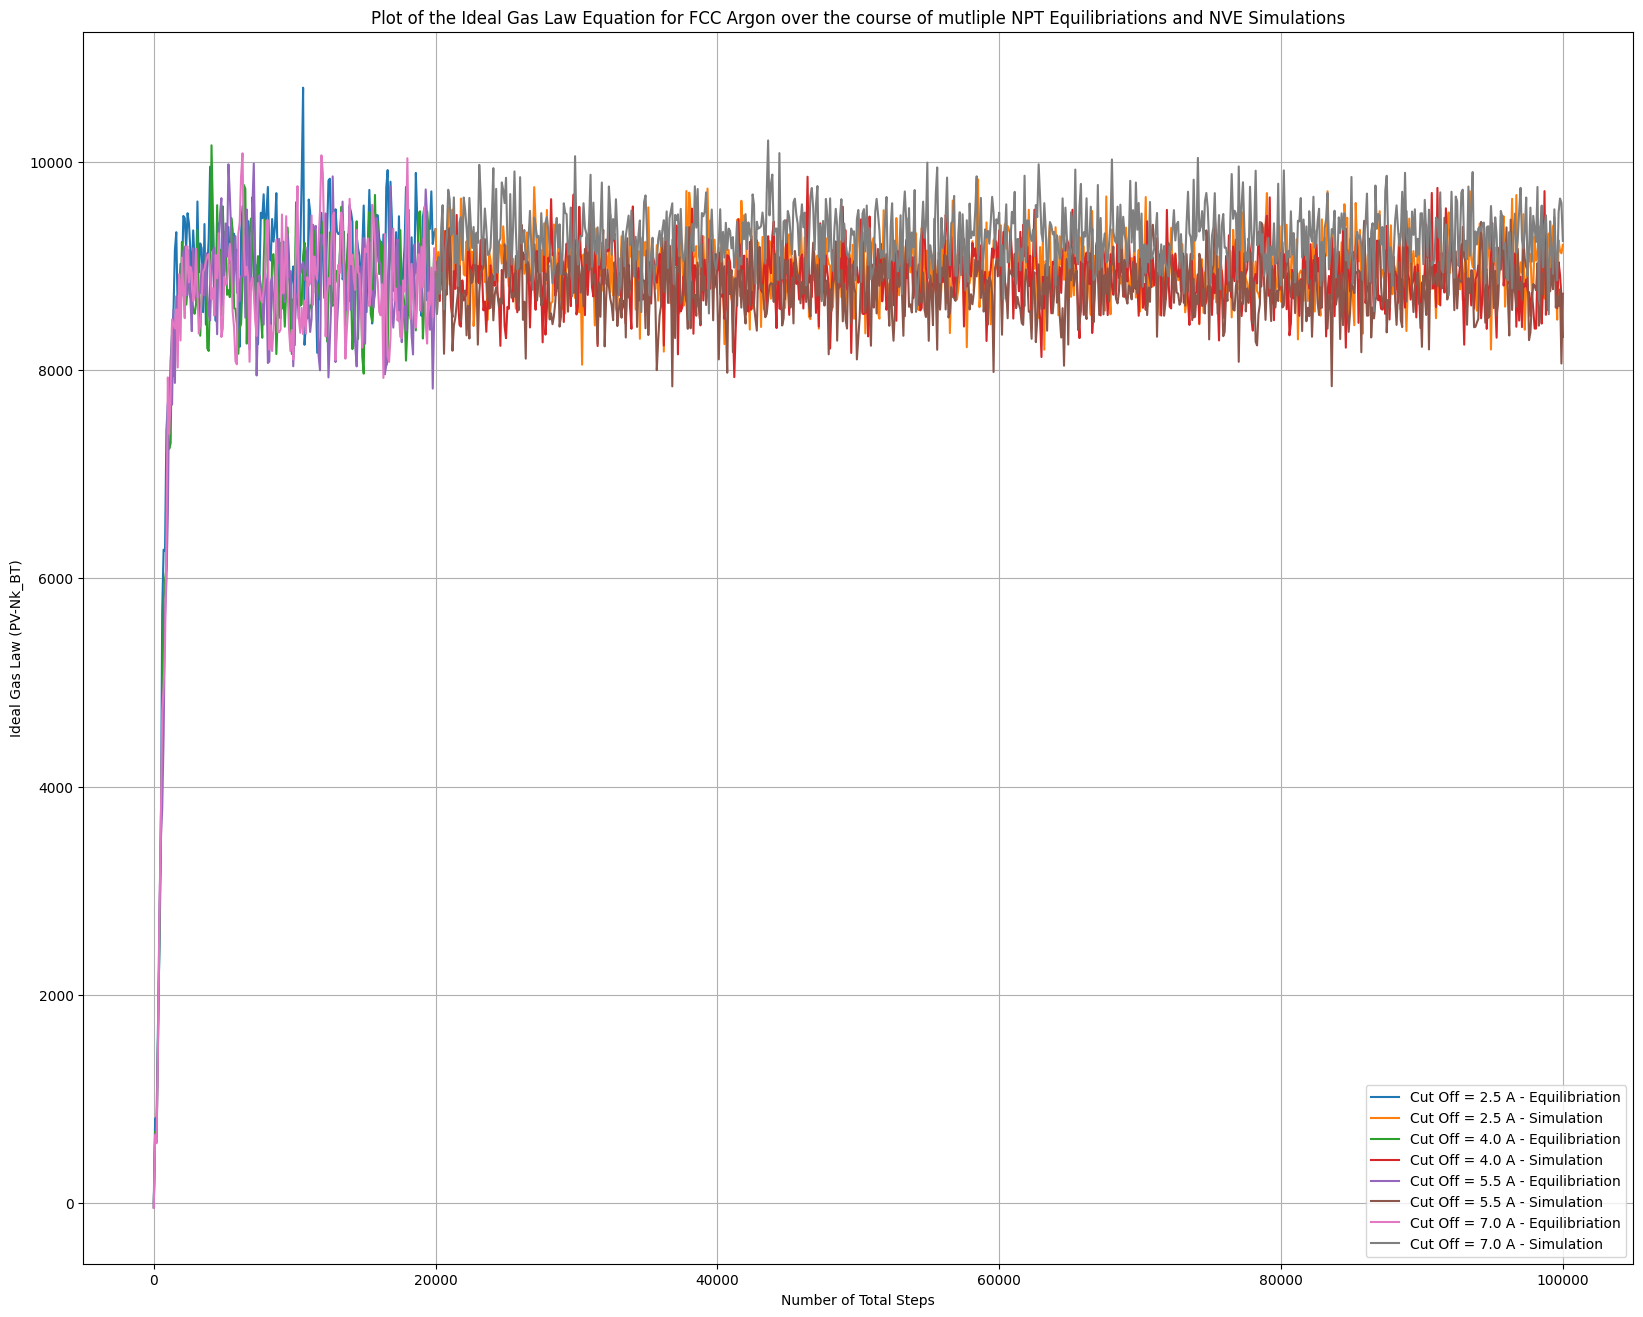

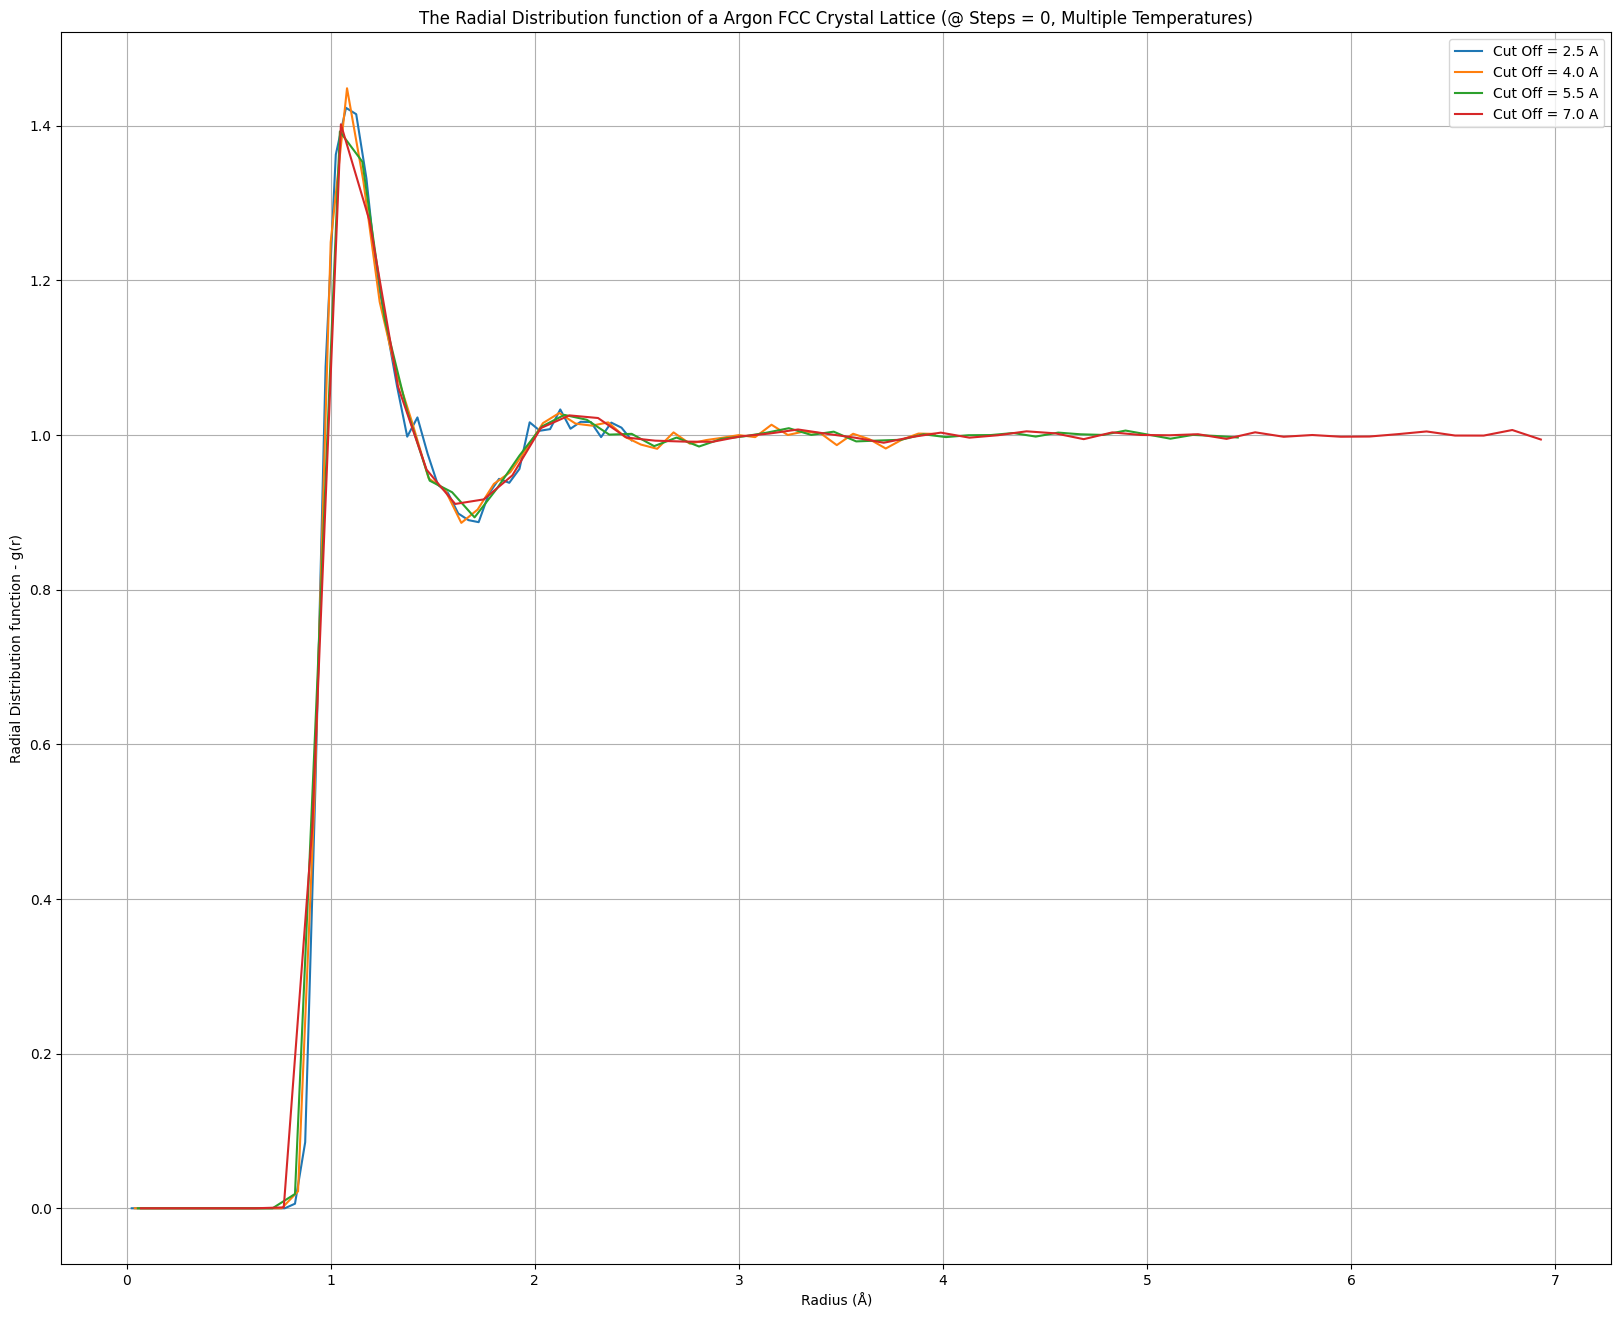

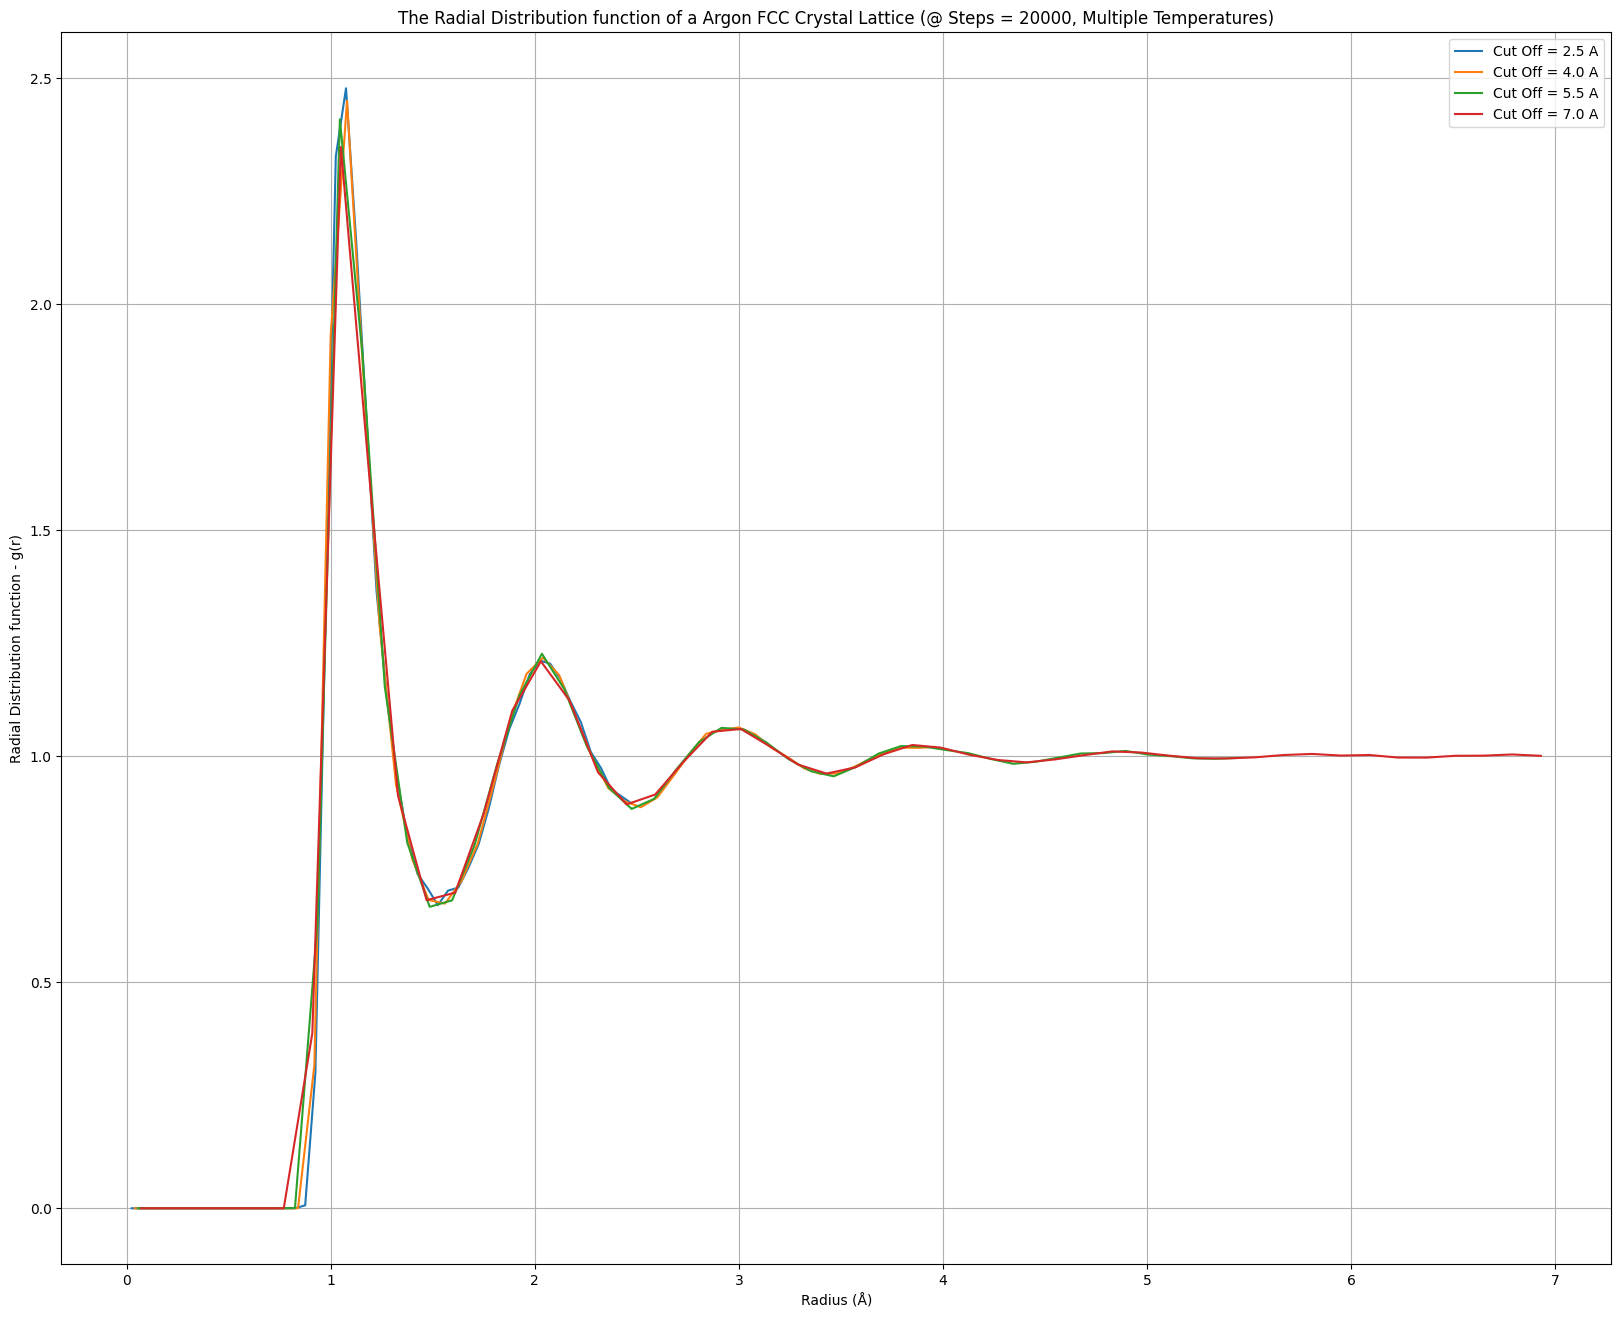

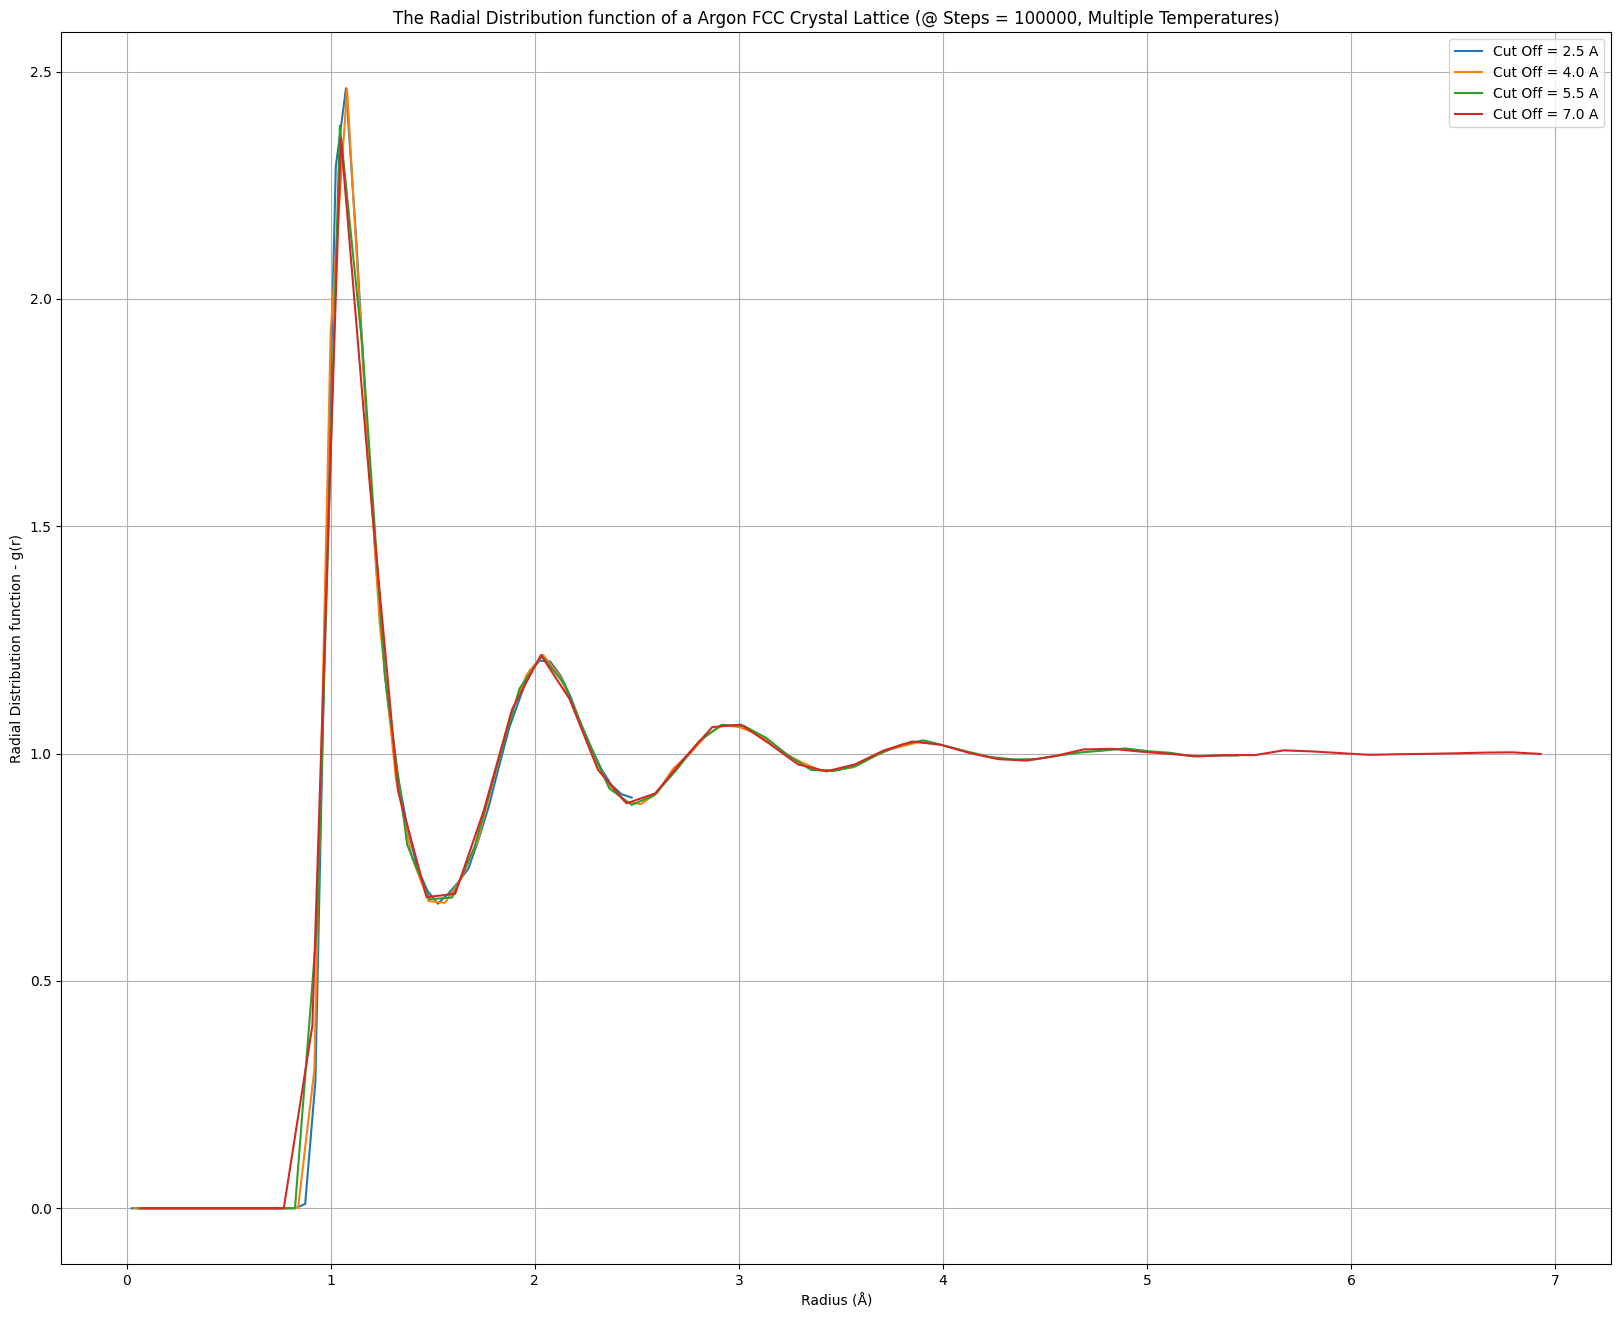

In [32]:
# Create the Labels
labels = ["Cut Off = 2.5 A","Cut Off = 4.0 A", "Cut Off = 5.5 A", "Cut Off = 7.0 A"]


# Arrange the PVNRT Dataframes into arrays for multi plotting
df_eq = [E5_C1_eq, E5_C2_eq, E5_C3_eq, E5_C4_eq]
df = [E5_C1, E5_C2, E5_C3, E5_C4]

# PLot the PVNRT Comaparisons
plot_multi_PVRNT(df_eq, df, labels)

# Arrange the RDf Dataframes into arraus for multi plotting
dfs1 = [E5_C1_RDF_eq[0], E5_C2_RDF_eq[0], E5_C3_RDF_eq[0], E5_C4_RDF_eq[0]]
dfs2 = [E5_C1_RDF_eq[-1], E5_C2_RDF_eq[-1], E5_C3_RDF_eq[-1], E5_C4_RDF_eq[-1]]
dfs3 = [E5_C1_RDF[-1], E5_C2_RDF[-1], E5_C3_RDF[-1], E5_C4_RDF[-1]]

# Plot the RDF Comparisons
plot_multi_RDF(dfs1, "@ Steps = 0, Multiple Temperatures", labels)
plot_multi_RDF(dfs2, "@ Steps = 20000, Multiple Temperatures", labels)
plot_multi_RDF(dfs3, "@ Steps = 100000, Multiple Temperatures", labels)

## Questions
----

### How do results change with the cutoff?
----
None of the results ended up changing that much, the PV-Nk_BT Graphs are nearly identical with the exception of slightly different noise and slightly varying averages, but overall they are all nearly equivalent. This could come from small variances from the extra information from the larger cutoff  radius. What was really noticed was that the calculation times drastically incresed. This makes sense because with a larger cutoff we are including many more atoms that will factor into the force applied on a single atom. But since these atoms are so far away they have near no contributions and are "wasteful" for our calculations. This ends up showing how we can optimize the simulation for speed while still getting nearly the same results.

### Any differences in RDF? Why?
-----
Just like above, there are essentially no differences in the RDF plots, this is because the extra cutoff distance includes atoms that have nearly no effect on the force of the calculated atom. Since those further atoms have nearly no contribution, the spread of the atoms in the volume over the course of the simualtion will not be affected greatly and this in turn will not modify the RDF function. We do notice that the larger cutoffs are capable of calculating the RDF further away, and the larger cut offs seem to have smoother distributions, but this could be because we are using too many bins for the earlier calculations and smaller cutoff distances

# Exercise 6 : Mean Squared Displacement and Diffusion Coefficient
----
## Instructions
---
1. Use ‘compute msd‘ in LAMMPS.
2. Calculate diffusion coefficient using Einstein relation:

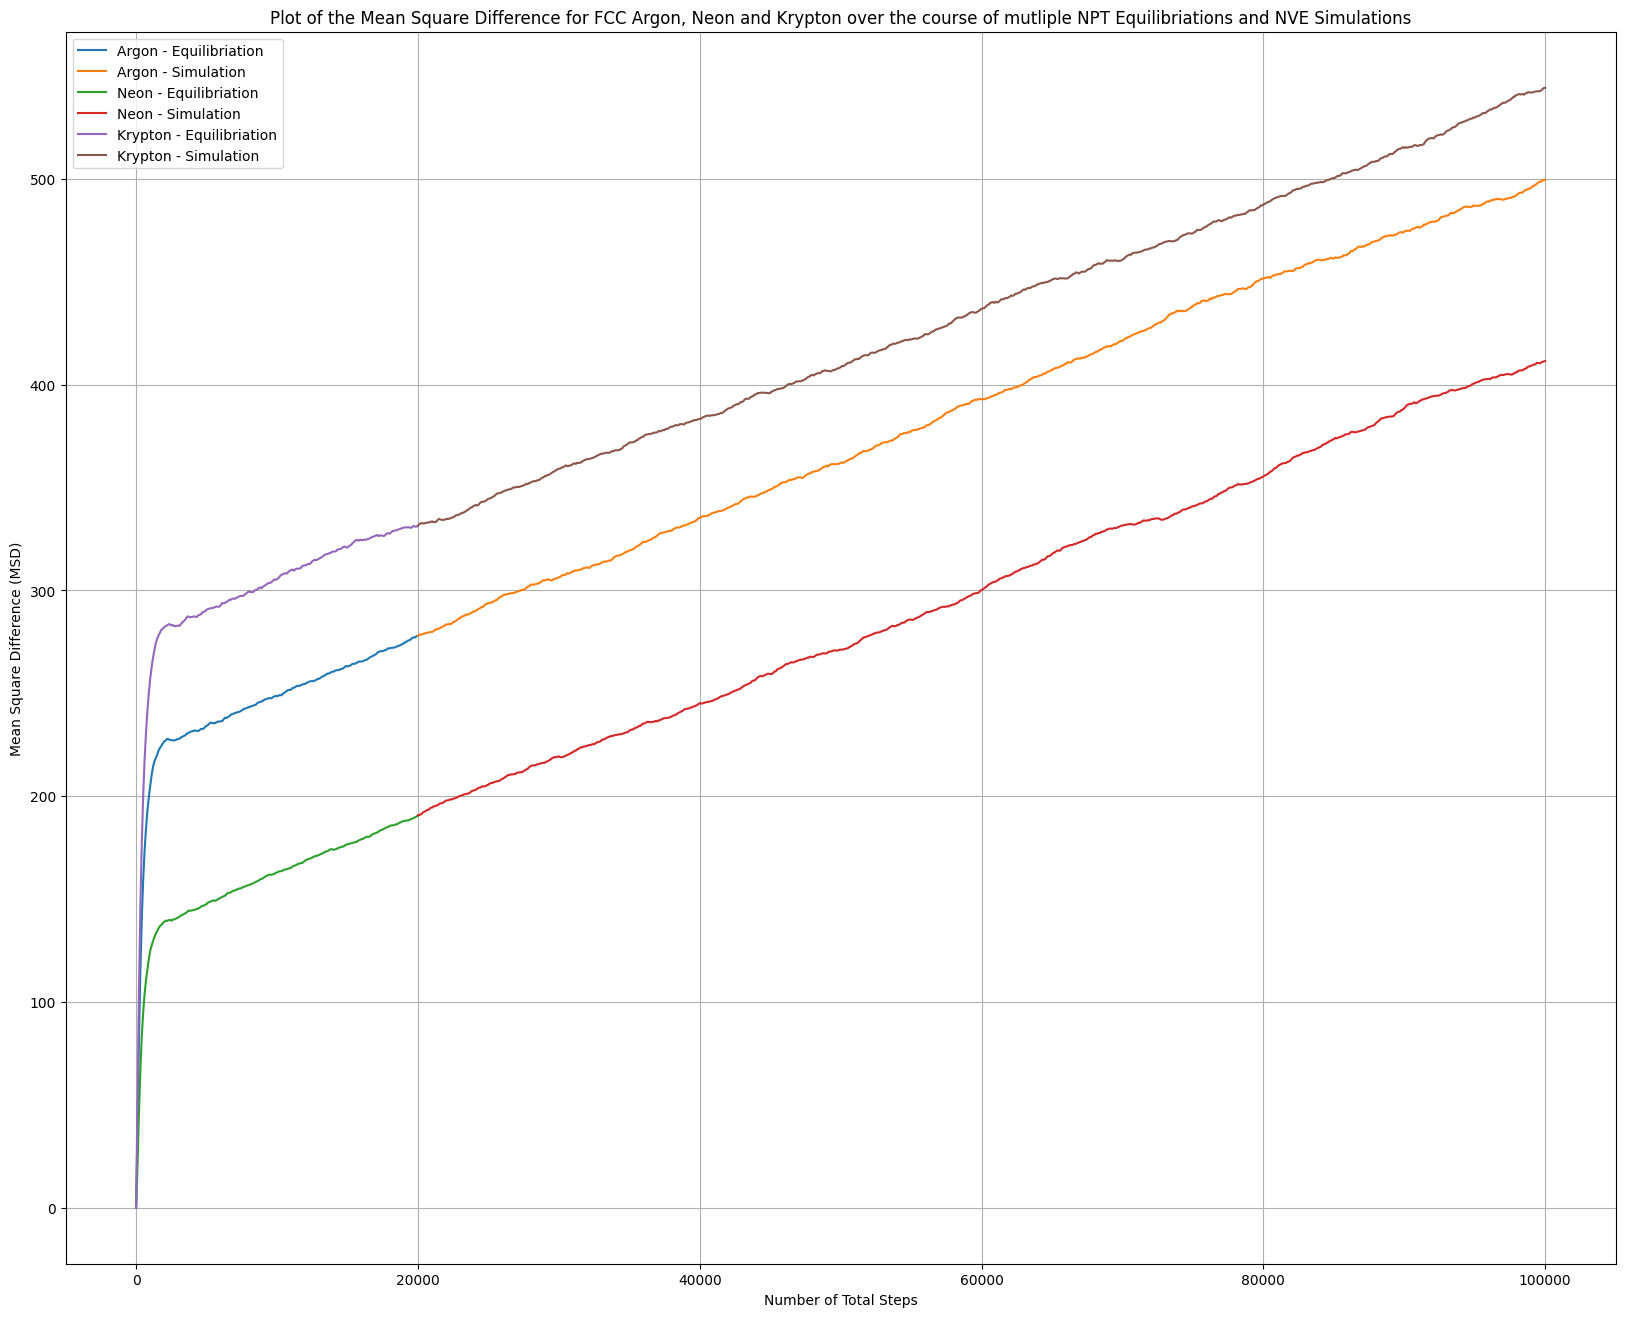

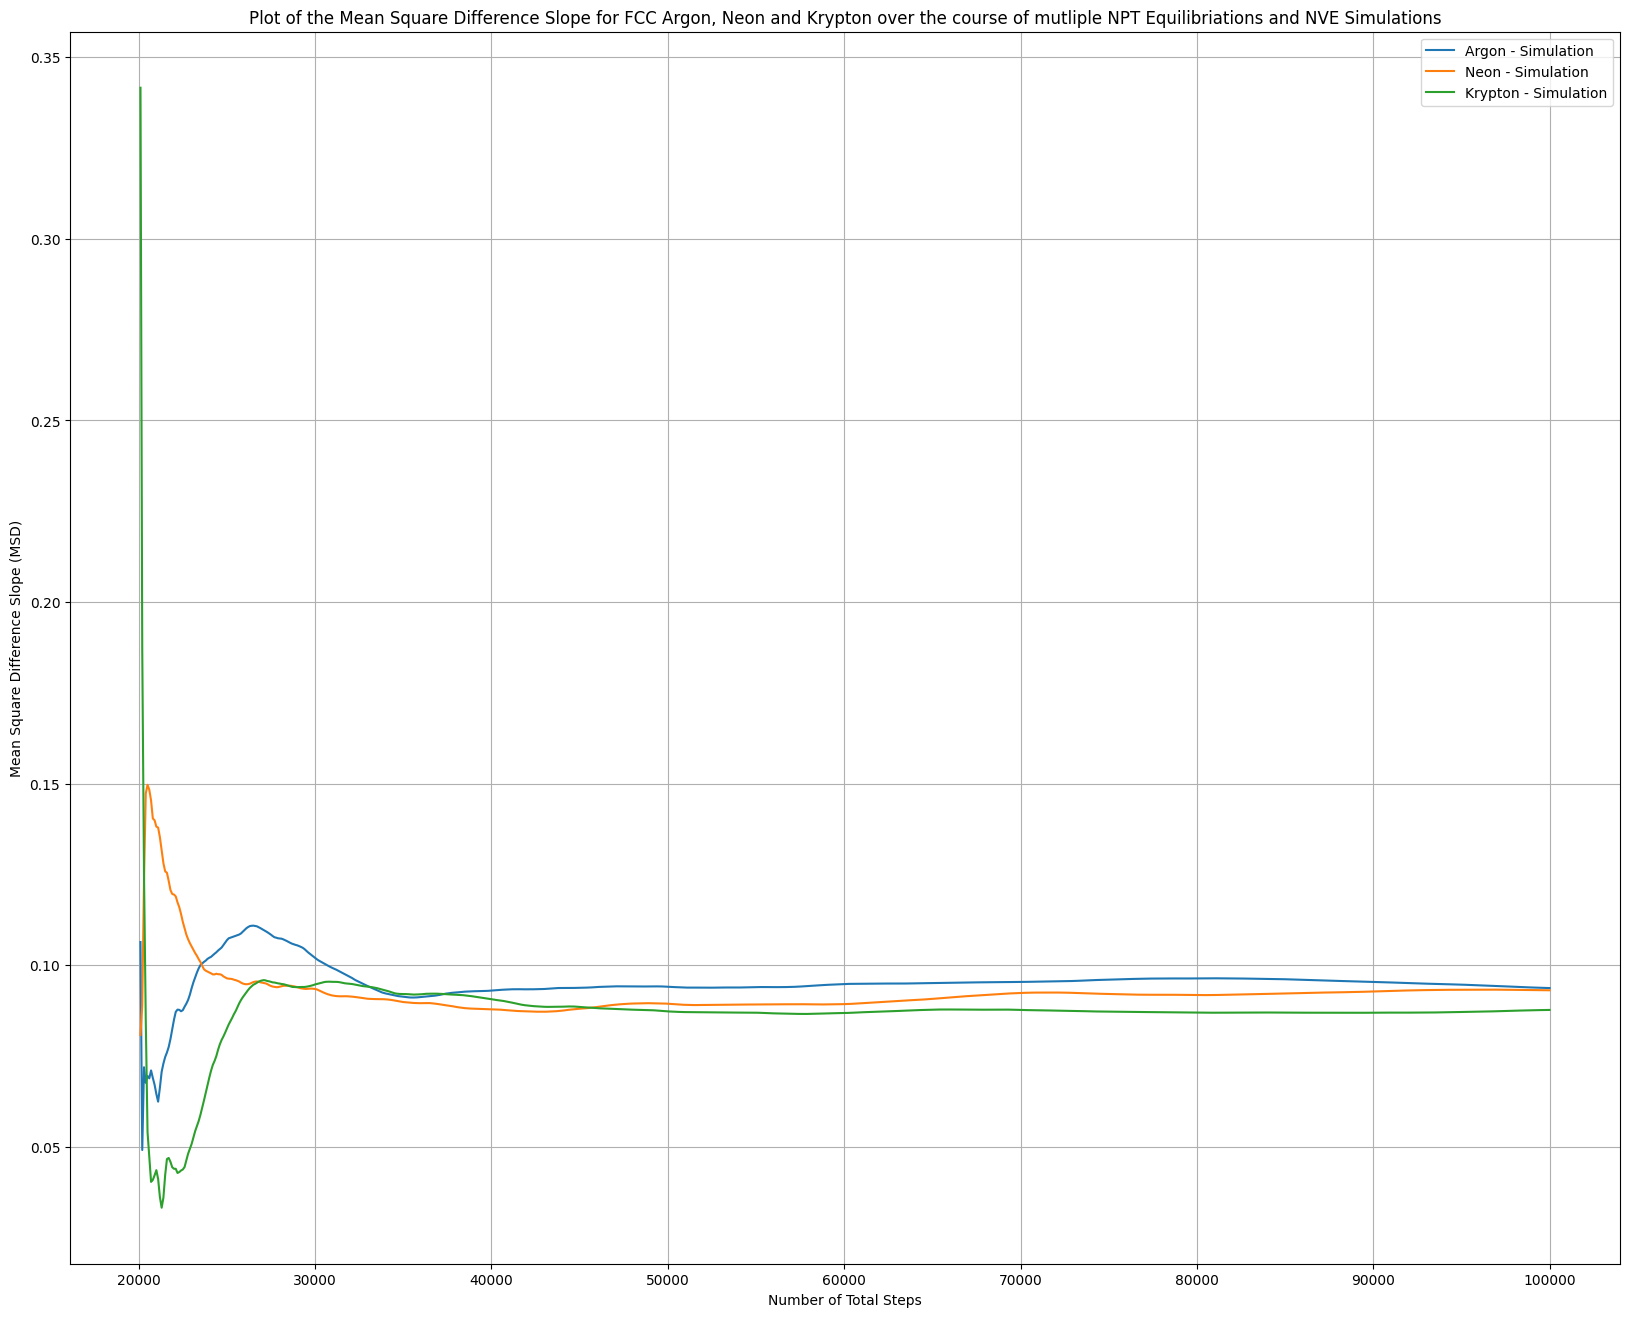

In [33]:
# Put dataframes into Arrays
dfs_eq = [E6_Ar_eq, E6_Ne_eq, E6_Kr_eq]
dfs = [E6_Ar, E6_Ne, E6_Kr]
labels = ["Argon", "Neon", "Krypton"]

# Plot the MSD Data
plot_multi_MSD(dfs_eq, dfs, labels)
plot_multi_MSD_Slope(dfs_eq, dfs, labels)

## Questions
----
### Is MSD linear with time? What does it indicate?
----
Yes the Mean Sqared Difference (MSD) is linear with time after the equilibriation phase, this indicates that brownian motion is achieved and the particles are diffusing normally within the solid, we can also see the slope, or diffusion coefficient settle within the second graph. This means we have found a consistent diffusion coefficient

### Compare diffusion for different atom types.
----
When comparing the diffusion with other atom types, we see that the heavier atoms have the same Diffusion coefficient as things settle within the volume which makes sense since nothing within the volume are stopping them from diffusing. What is interesting is that the heavier atom Krypton starts at a higher MSD. At first thought we would expect it to be lower, but this is likely due to the bigger size and extra electrons providing more coloumbic force during the simulation making them move faster by then end of the equilibriation phase